# REMIT Data Analysis

## Data Load

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
remit_data_raw = pd.read_csv('REMIT_2021_2024.csv')
dates = pd.read_csv('Dates_SP_2021_2024.csv')
BMUfueltypes = pd.read_csv("BMUFuelType.csv")

## Data Cleaning

In [3]:
# Convert 'publishTime' to datetime format 
remit_data_raw['publishTime'] = pd.to_datetime(remit_data_raw['publishTime']).dt.tz_localize(None)
dates['StartTime'] = pd.to_datetime(dates['StartTime']).dt.tz_localize(None)
remit_data = remit_data_raw.copy()

# Filter the data for 2023 onwards
remit_data = remit_data_raw[remit_data_raw['publishTime'] >= '2023-01-01']
dates = dates[dates['StartTime'] >= '2023-01-01']

In [ ]:
# Drop rows where there are missing values in normalCapacity, availableCapacity or unavailableCapacity
remit_data = remit_data.dropna(subset=['normalCapacity', 'availableCapacity', 'unavailableCapacity'])

# Drop dataset, relatedInformation, outageProfile, affectedArea and durationUncertainty columns
remit_data = remit_data.drop(columns=['dataset', 'relatedInformation', 'outageProfile', 'affectedArea', 'durationUncertainty'])

# Drop row where availableCapacity is 300000- random outlier in the data
remit_data = remit_data[remit_data['availableCapacity'] != 300000]

# For Fossil Hard Coal rows, only keep those with participantId = EECL or WBURTONB
remit_data = remit_data[~((remit_data['fuelType'] == 'Fossil Hard coal') & (~remit_data['participantId'].isin(['EECL', 'WBURTONB'])))]

# Reset index for the filtered data
remit_data.reset_index(drop=True, inplace=True)

## Fuel Type Data Cleaning

In [5]:
# Display all unique (assetId, participantId) pairs with a known fuelType
fuel_types = remit_data[['assetId', 'participantId', 'fuelType']].drop_duplicates()
fuel_types

assetId participantId       fuelType
0         T_PINFB-2       ZENOBE2          Other
1         T_PINFB-1       ZENOBE2          Other
4         T_MOWEO-3         MOWEL  Wind Offshore
5         T_MOWEO-2         MOWEL  Wind Offshore
6         T_MOWEO-1         MOWEL  Wind Offshore
...             ...           ...            ...
101257   I_IEG-GRN1      GREENLNK            NaN
102266    E_JAMBB-1         TESLA            NaN
102268    E_JAMBB-2         TESLA            NaN
102291     E_CORB-1         CORBY            NaN
102613  2__JUKPR001          UKPR            NaN

[342 rows x 3 columns]

In [6]:
# For each assetId in fuel_types, find the BMRS FUEL TYPE from BMUfueltypes

# Merge to find BMRS FUEL TYPE for missing assetIds
fuel_lookup = fuel_types.merge(
    BMUfueltypes[['SETT UNIT ID','BMRS FUEL TYPE','REG FUEL TYPE']].rename(columns={'SETT UNIT ID': 'assetId'}),
    on='assetId',
    how='left'
)

# Show assetId, participantId, and found BMRS FUEL TYPE
fuel_lookup

assetId participantId       fuelType BMRS FUEL TYPE REG FUEL TYPE
0      T_PINFB-2       ZENOBE2          Other          OTHER       BATTERY
1      T_PINFB-1       ZENOBE2          Other          OTHER       BATTERY
2      T_MOWEO-3         MOWEL  Wind Offshore           WIND          WIND
3      T_MOWEO-2         MOWEL  Wind Offshore           WIND          WIND
4      T_MOWEO-1         MOWEL  Wind Offshore           WIND          WIND
..           ...           ...            ...            ...           ...
337   I_IEG-GRN1      GREENLNK            NaN        INTGRNL       INTGRNL
338    E_JAMBB-1         TESLA            NaN          OTHER       BATTERY
339    E_JAMBB-2         TESLA            NaN          OTHER       BATTERY
340     E_CORB-1         CORBY            NaN           CCGT          CCGT
341  2__JUKPR001          UKPR            NaN          OTHER       BATTERY

[342 rows x 5 columns]

In [ ]:
## Cleaning up data

# Sort by column: 'fuelType' (ascending)
fuel_lookup = fuel_lookup.sort_values(['fuelType'], na_position='first')

# Create a copy of the fuelType column
fuel_lookup['fuelType_copy'] = fuel_lookup['fuelType']

fuel_lookup['fuelType_copy'] = fuel_lookup['fuelType_copy'].fillna(fuel_lookup['BMRS FUEL TYPE'])

# Sort by column: 'fuelType_copy' (ascending)
fuel_lookup = fuel_lookup.sort_values(['fuelType_copy'], na_position='first')

# Update 'fuelType_copy' where it is 'OTHER' or 'Other' with 'REG FUEL TYPE'
fuel_lookup.loc[fuel_lookup['fuelType_copy'].isin(['OTHER', 'Other']), 'fuelType_copy'] = fuel_lookup['REG FUEL TYPE']

# Sort by column: 'fuelType_copy' (ascending)
fuel_lookup = fuel_lookup.sort_values(['fuelType_copy'], na_position='first')

# Rename assetId row with MRWD-1 to T_MRWD-1
fuel_lookup.loc[fuel_lookup['assetId'] == 'MRWD-1', 'assetId'] = 'T_MRWD-1'

# Set T_MRWD-1 to CCGT
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_MRWD-1', 'fuelType_copy'] = 'CCGT'

# Set I_IED-GRN1 to INTGRNL
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-GRN1', 'fuelType_copy'] = 'INTGRNL'

# Rename 'KTHRS-1' to 'T_KTHRS-1' and set 'fuelType_copy' to 'CCGT'
fuel_lookup.loc[fuel_lookup['assetId'] == 'KTHRS-1', ['assetId', 'fuelType_copy']] = ['T_KTHRS-1', 'CCGT']

# Rename 'MARK-1' to 'E_MARK-1' and set 'fuelType_copy' to 'Biomass' 
fuel_lookup.loc[fuel_lookup['assetId'] == 'MARK-1', ['assetId', 'fuelType_copy']] = ['E_MARK-1', 'Biomass']

# Set STATKRA1 assets to battery
fuel_lookup.loc[fuel_lookup['assetId'].isin(['LRDSC-1', 'LRDSC-2', 'KTHRS-2']), 'fuelType_copy'] = 'BATTERY'

# Set T_WISHD-1 to BATTERY
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_WISHD-1', 'fuelType_copy'] = 'BATTERY'

# Drop rows where fuel type is missing
fuel_lookup = fuel_lookup.dropna(subset=['fuelType_copy'])


# Update row names to 'Hydropower' for consistency
fuel_lookup.loc[fuel_lookup['fuelType_copy'].isin(['PS', 'Hydro Water Reservoir', 'Hydro Pumped Storage']), 'fuelType_copy'] = 'Hydropower'
fuel_lookup['fuelType_copy'] = fuel_lookup.apply(
    lambda row: row['BMRS FUEL TYPE'] if row['fuelType_copy'] == 'Fossil Gas' else row['fuelType_copy'], axis=1
)

# Update fuelType_copy for assetId T_DOREW-1 to 'Wind Onshore'
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_DOREW-1', 'fuelType_copy'] = 'Wind Onshore'

# Update fuelType_copy for assetId T_BEATO-2 to 'Wind Offshore'
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_BEATO-2', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'].isin(['T_SHRSW-1', 'T_SHRSW-2']), 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for assetId T_BEATO-1 to 'Wind Offshore'
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_BEATO-1', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'E_BRYBW-1', 'fuelType_copy'] = 'Wind Onshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'E_ASHWW-1', 'fuelType_copy'] = 'Wind Onshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_BEATO-3', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_NNGAO-2', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'E_BABAW-1', 'fuelType_copy'] = 'Wind Onshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_MOWWO-1', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_DOREW-2', 'fuelType_copy'] = 'Wind Onshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_TWSHW-1', 'fuelType_copy'] = 'Wind Onshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_NNGAO-1', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_BEATO-4', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_MOWWO-3', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_GRGBW-1', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_MOWWO-2', 'fuelType_copy'] = 'Wind Offshore'

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'T_MOWWO-4', 'fuelType_copy'] = 'Wind Offshore'

# Drop rows where fuelType_copy equals 'Other renewable'
fuel_lookup = fuel_lookup[fuel_lookup['fuelType_copy'] != 'Other renewable']

# Sort by column: 'fuelType_copy' (ascending)
fuel_lookup = fuel_lookup.sort_values(['fuelType_copy'], na_position='first')

# Rename SCCL-2 to T_SCCL-2 and set fuelType_copy to CCGT
fuel_lookup.loc[fuel_lookup['assetId'] == 'SCCL-2', ['assetId', 'fuelType_copy']] = ['T_SCCL-2', 'CCGT']

# Update fuelType_copy for specific assetIds
fuel_lookup.loc[fuel_lookup['assetId'] == 'GCHP', 'fuelType_copy'] = 'CCGT'

# Rename assetId and set fuelType_copy
fuel_lookup.loc[fuel_lookup['assetId'] == 'MWRD-1', ['assetId', 'fuelType_copy']] = ['T_MRWD-1', 'CCGT']

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'].isin(['I_IND-NEMO1', 'I_ING-NEMO1']), 'fuelType_copy'] = 'IC NEMO' # IC NEMO

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-IFA2', 'fuelType_copy'] = 'IC France 2'  # IC France 2

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-IFA2', 'fuelType_copy'] = 'IC France 2'  # IC France 2

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-EWIC1', 'fuelType_copy'] = 'IC East West'  # IC East West

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-EWIC1', 'fuelType_copy'] = 'IC East West'  # IC East West

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-ELEC1', 'fuelType_copy'] = 'IC Eleclink'  # IC Eleclink

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-ELEC1', 'fuelType_copy'] = 'IC Eleclink'  # IC Eleclink

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-FRAN1', 'fuelType_copy'] = 'IC France 1'  # IC France 1

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-FRAN1', 'fuelType_copy'] = 'IC France 1'  # IC France 1

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-GRN1', 'fuelType_copy'] = 'IC Greenlink'  # IC Greenlink

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-GRN1', 'fuelType_copy'] = 'IC Greenlink'  # IC Greenlink

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-MOYL1', 'fuelType_copy'] = 'IC Moyle'  # IC Moyle

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-MOYL1', 'fuelType_copy'] = 'IC Moyle'  # IC Moyle

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-VKL1', 'fuelType_copy'] = 'IC Viking'  # IC Viking

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-VKL1', 'fuelType_copy'] = 'IC Viking'  # IC Viking

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IED-NSL1', 'fuelType_copy'] = 'IC North Sea'  # IC North Sea

# Rename fuelType_copy for specific assetIDs
fuel_lookup.loc[fuel_lookup['assetId'] == 'I_IEG-NSL1', 'fuelType_copy'] = 'IC North Sea'  # IC North Sea

# Rename fuel type for specific asset IDs
fuel_lookup.loc[fuel_lookup['assetId'].isin(['T_WBURB-43', 'T_WBURB-41']), 'fuelType_copy'] = 'BATTERY'

# Drop rows where assetId is E_BTNHL-1
fuel_lookup = fuel_lookup[fuel_lookup['assetId'] != 'E_BTNHL-1']

# Rename rows in 'fuelType_copy' column from 'BIOMASS' to 'Biomass'
fuel_lookup['fuelType_copy'] = fuel_lookup['fuelType_copy'].replace('BIOMASS', 'Biomass')

# Rename 'BATTERY' to 'Battery' in 'fuelType_copy'
fuel_lookup['fuelType_copy'] = fuel_lookup['fuelType_copy'].replace('BATTERY', 'Battery')

# Drop specified columns from fuel_lookup
fuel_lookup = fuel_lookup.drop(columns=["fuelType", "BMRS FUEL TYPE", "REG FUEL TYPE"])

# Rename column fuelType_copy to fuelType
fuel_lookup = fuel_lookup.rename(columns={"fuelType_copy": "fuelType"})

In [8]:
# Rename assetId rows 
remit_data.loc[remit_data['assetId'] == 'MRWD-1', 'assetId'] = 'T_MRWD-1'
remit_data.loc[remit_data['assetId'] == 'KTHRS-1', 'assetId'] = 'T_KTHRS-1'
remit_data.loc[remit_data['assetId'] == 'MARK-1', 'assetId'] = 'E_MARK-1'
remit_data.loc[remit_data['assetId'] == 'SCCL-2', 'assetId'] = 'T_SCCL-2'
remit_data.loc[remit_data['assetId'] == 'MWRD-1', 'assetId'] = 'T_MRWD-1'

# Perform inner merge to keep only matching assetId + participantId pairs
merged_data = remit_data.merge(
    fuel_lookup[['assetId', 'participantId', 'fuelType']],
    on=['assetId', 'participantId'],
    how='inner',
    suffixes=('', '_new')
)

# Replace the old fuelType column with the one from fuel_lookup
merged_data['fuelType'] = merged_data['fuelType_new']
merged_data.drop(columns=['fuelType_new'], inplace=True)
merged_data.reset_index(drop=True, inplace=True)

# Rename df
remit_data = merged_data

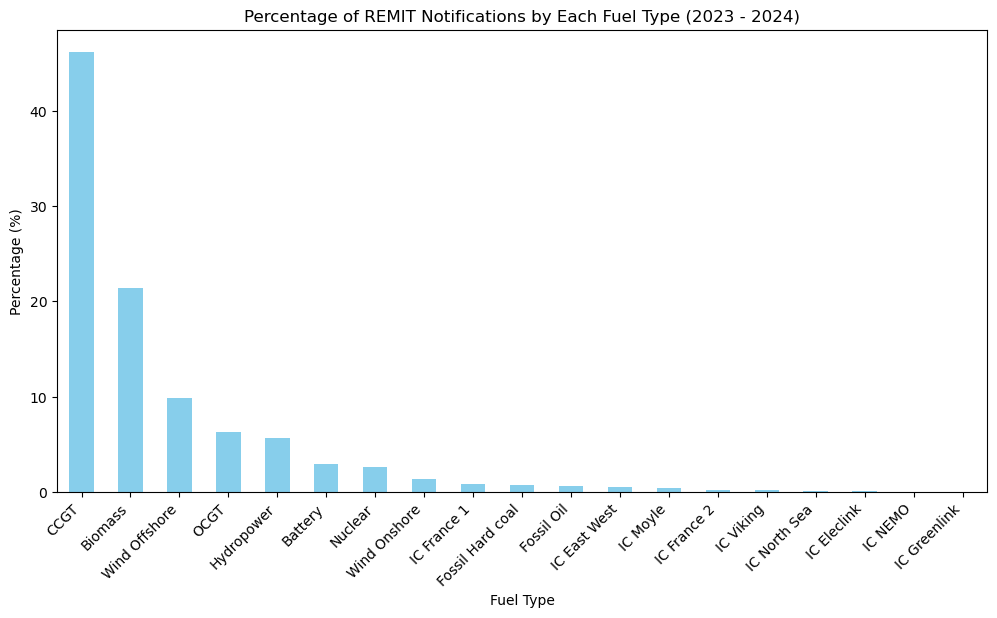

In [9]:
# Unique values in the fuelType column
unique_fuel_types = remit_data['fuelType'].unique()

# Percentage of each fuel type
fuel_type_counts = remit_data['fuelType'].value_counts(normalize=True) * 100
# Create a bar plot for the percentage of each fuel type
plt.figure(figsize=(12, 6))
fuel_type_counts.plot(kind='bar', color='skyblue')      
plt.title('Percentage of REMIT Notifications by Each Fuel Type (2023 - 2024)')
plt.xlabel('Fuel Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45,ha='right')
plt.show()

In [10]:
remit_data[['normalCapacity', 'availableCapacity', 'unavailableCapacity']].describe()

normalCapacity  availableCapacity  unavailableCapacity
count   111551.000000      111551.000000        111551.000000
mean       465.199102         209.219077           247.772591
std        342.704865         266.615058           250.265871
min      -1480.000000         -12.000000           -33.000000
25%        133.000000           0.000000            40.000000
50%        450.000000          89.000000           150.000000
75%        660.000000         370.000000           411.000000
max       2000.000000        2000.000000          2000.000000

In [11]:
# Create a DataFrame with each affectedUnit and its corresponding fuelType
affected_unit_fuel = remit_data[['affectedUnit', 'fuelType']].drop_duplicates().reset_index(drop=True)

# Optional: sort by affectedUnit for clarity
affected_unit_fuel = affected_unit_fuel.sort_values(by='affectedUnit').reset_index(drop=True)

# Save to CSV 
affected_unit_fuel.to_csv("affected_unit_fuel.csv", index=False)

# Show the result
affected_unit_fuel

affectedUnit       fuelType
0      AG-JUKP01        Battery
1        ARCHW-1   Wind Onshore
2        BDCHW-1   Wind Onshore
3         BLLA-1   Wind Onshore
4        BRBEO-1  Wind Offshore
..           ...            ...
318      WLNYO-2  Wind Offshore
319      WLNYO-3  Wind Offshore
320      WLNYO-4  Wind Offshore
321      WLNYW-1  Wind Offshore
322      WTMSO-1  Wind Offshore

[323 rows x 2 columns]

## Data Aggregation

In [12]:
from datetime import datetime
import pandas as pd

# Ensure datetime columns are timezone-naive
remit_data['eventStartTime'] = pd.to_datetime(remit_data['eventStartTime']).dt.tz_localize(None)
remit_data['eventEndTime'] = pd.to_datetime(remit_data['eventEndTime']).dt.tz_localize(None)
remit_data['publishTime'] = pd.to_datetime(remit_data['publishTime'])

# Convert unavailableCapacity to numeric
remit_data['unavailableCapacity'] = pd.to_numeric(remit_data['unavailableCapacity'], errors='coerce').fillna(0)

# Get all unique units with their fuelType
unit_info = remit_data.drop_duplicates(subset=['affectedUnit'])[['affectedUnit', 'fuelType']]
all_units = unit_info['affectedUnit'].unique()
unit_fuel_mapping = unit_info.set_index('affectedUnit')['fuelType'].to_dict()

# All unavailability types
all_unavail_types = remit_data['unavailabilityType'].dropna().unique()

# Store results
results = []
last_day = None

# Loop through each half-hour interval
for interval in dates['StartTime']:
    current_day = interval.date()
    if current_day != last_day:
        print(f"Processing day: {current_day}")
        last_day = current_day

    # Filter events active during this interval
    active_rows = remit_data[
        (remit_data['eventStartTime'] <= interval) &
        (remit_data['eventEndTime'] > interval)
    ]

    if not active_rows.empty:
        # Keep latest revision per unit
        sorted_rows = (
            active_rows
            .sort_values(['affectedUnit', 'revisionNumber', 'publishTime'], ascending=[True, False, False])
            .drop_duplicates(subset='affectedUnit', keep='first')
        )

        # Filter active events only
        active_events = sorted_rows #[sorted_rows['eventStatus'].str.lower() == 'active']

        # Build lookup for unavailable capacity by unit + unavailability type
        capacity_map = active_events.set_index(['affectedUnit', 'unavailabilityType'])['unavailableCapacity'].to_dict()
    else:
        capacity_map = {}

    # Ensure every unit and unavailabilityType has a row
    for unit in all_units:
        for utype in all_unavail_types:
            results.append({
                'StartTime': interval,
                'affectedUnit': unit,
                'fuelType': unit_fuel_mapping.get(unit, 'Unknown'),
                'unavailabilityType': utype,
                'unavailableCapacity': capacity_map.get((unit, utype), 0)
            })

# Final DataFrame
unit_capacity_over_time = pd.DataFrame(results)

Processing day: 2023-01-01
Processing day: 2023-01-02
Processing day: 2023-01-03
Processing day: 2023-01-04
Processing day: 2023-01-05
Processing day: 2023-01-06
Processing day: 2023-01-07
Processing day: 2023-01-08
Processing day: 2023-01-09
Processing day: 2023-01-10
Processing day: 2023-01-11
Processing day: 2023-01-12
Processing day: 2023-01-13
Processing day: 2023-01-14
Processing day: 2023-01-15
Processing day: 2023-01-16
Processing day: 2023-01-17
Processing day: 2023-01-18
Processing day: 2023-01-19
Processing day: 2023-01-20
Processing day: 2023-01-21
Processing day: 2023-01-22
Processing day: 2023-01-23
Processing day: 2023-01-24
Processing day: 2023-01-25
Processing day: 2023-01-26
Processing day: 2023-01-27
Processing day: 2023-01-28
Processing day: 2023-01-29
Processing day: 2023-01-30
Processing day: 2023-01-31
Processing day: 2023-02-01
Processing day: 2023-02-02
Processing day: 2023-02-03
Processing day: 2023-02-04
Processing day: 2023-02-05
Processing day: 2023-02-06
P

In [13]:
# For affectedUnit = T_WBUPS-1 and T_WBUPS-2, set unavailableCapacity to 500 for Planned unavailabilityType and 0 for Unplanned unavailabilityType for dates from 2023-03-31
unit_capacity_over_time.loc[
    (unit_capacity_over_time['affectedUnit'].isin(['T_WBUPS-1', 'T_WBUPS-2'])) &
    (unit_capacity_over_time['StartTime'] >= '2023-03-31') &
    (unit_capacity_over_time['unavailabilityType'] == 'Planned'),
    'unavailableCapacity'   ] = 1000
unit_capacity_over_time.loc[
    (unit_capacity_over_time['affectedUnit'].isin(['T_WBUPS-1', 'T_WBUPS-2'])) &
    (unit_capacity_over_time['StartTime'] >= '2023-03-31') &
    (unit_capacity_over_time['unavailabilityType'] == 'Unplanned'),
    'unavailableCapacity'   ] = 0          

# For affectedUnit = RATS-1, RATS-2, RATS-3 and RATS-4, set unavailableCapacity to 500 for Planned unavailabilityType and 0 for Unplanned unavailabilityType for dates from 2024-09-30
unit_capacity_over_time.loc[
    (unit_capacity_over_time['affectedUnit'].isin(['RATS-1', 'RATS-2', 'RATS-3', 'RATS-4'])) &
    (unit_capacity_over_time['StartTime'] >= '2024-09-30') &
    (unit_capacity_over_time['unavailabilityType'] == 'Planned'),
    'unavailableCapacity'   ] = 500
unit_capacity_over_time.loc[
    (unit_capacity_over_time['affectedUnit'].isin(['RATS-1', 'RATS-2', 'RATS-3', 'RATS-4'])) &
    (unit_capacity_over_time['StartTime'] >= '2024-09-30') &
    (unit_capacity_over_time['unavailabilityType'] == 'Unplanned'),
    'unavailableCapacity'   ] = 0

# For affectedUnit = RATSGT-2 and RATSGT-4, set unavailableCapacity to 18 for Planned unavailabilityType and 0 for Unplanned unavailabilityType for dates from 2024-09-30
unit_capacity_over_time.loc[
    (unit_capacity_over_time['affectedUnit'].isin(['RATSGT-2', 'RATSGT-4'])) &
    (unit_capacity_over_time['StartTime'] >= '2024-09-30') &
    (unit_capacity_over_time['unavailabilityType'] == 'Planned'),
    'unavailableCapacity'   ] = 18
unit_capacity_over_time.loc[
    (unit_capacity_over_time['affectedUnit'].isin(['RATSGT-2', 'RATSGT-4'])) &
    (unit_capacity_over_time['StartTime'] >= '2024-09-30') &
    (unit_capacity_over_time['unavailabilityType'] == 'Unplanned'),
    'unavailableCapacity'   ] = 0

In [14]:
# Drop rows where FuelType is 'IC Greenlink'
unit_capacity_over_time = unit_capacity_over_time[unit_capacity_over_time['fuelType'] != 'IC Greenlink']

# Rename oil and coal
unit_capacity_over_time['fuelType'] = (
    unit_capacity_over_time['fuelType']
    .replace({
        'Fossil Oil': 'Oil',
        'Fossil Hard coal': 'Coal'
    })
)

# Drop spaces from names
unit_capacity_over_time['fuelType'] = (
    unit_capacity_over_time['fuelType']
    .str.replace(' ', '_', regex=False)
)

In [15]:
## Additional processing steps (If needed)
# Rename interconnectors
unit_capacity_over_time['fuelType'] = (
    unit_capacity_over_time['fuelType']
    .replace({
        'IC_Moyle': 'Interconnector',
        'IC_Eleclink': 'Interconnector',
        'IC_France_1': 'Interconnector',
        'IC_France_2': 'Interconnector',
        'IC_East_West': 'Interconnector',
        'IC_NEMO': 'Interconnector',
        'IC_North_Sea': 'Interconnector',
        'IC_Viking': 'Interconnector'
    })
)

# Drop oil and battery
unit_capacity_over_time = unit_capacity_over_time[unit_capacity_over_time['fuelType'] != 'Oil']
unit_capacity_over_time = unit_capacity_over_time[unit_capacity_over_time['fuelType'] != 'Battery']
unit_capacity_over_time = unit_capacity_over_time[unit_capacity_over_time['fuelType'] != 'Coal']

In [16]:
# Sum number of individual generators by fuel type
unique_units_per_fuel = (
    unit_capacity_over_time.groupby("fuelType")["affectedUnit"]
    .nunique()
    .reset_index(name="unique_units")
)

print(unique_units_per_fuel)

         fuelType  unique_units
0         Biomass            14
1            CCGT            81
2      Hydropower            28
3  Interconnector            16
4         Nuclear            10
5            OCGT            19
6   Wind_Offshore            83
7    Wind_Onshore            38


In [17]:
## Unit Capacity Over Time pivoted (Planned)
# Filter for Planned unavailabilityType
individual_unit_capacity_planned = unit_capacity_over_time[unit_capacity_over_time['unavailabilityType'] == 'Planned']

# Drop FuelType and unavailabilityType columns
individual_unit_capacity_planned = individual_unit_capacity_planned.drop(columns=['fuelType', 'unavailabilityType'])

# Pivot the DataFrame to have affectedUnit as columns
individual_unit_capacity_planned = individual_unit_capacity_planned.pivot(index='StartTime', columns='affectedUnit', values='unavailableCapacity').fillna(0)

# Save the df 
individual_unit_capacity_planned.to_csv('Individual_Unit_Capacity_Planned.csv')

In [18]:
## Unit Capacity Over Time pivoted (Unplanned)
# Filter for Planned unavailabilityType
individual_unit_capacity_unplanned = unit_capacity_over_time[unit_capacity_over_time['unavailabilityType'] == 'Unplanned']

# Drop FuelType and unavailabilityType columns
individual_unit_capacity_unplanned = individual_unit_capacity_unplanned.drop(columns=['fuelType', 'unavailabilityType'])

# Pivot the DataFrame to have affectedUnit as columns
individual_unit_capacity_unplanned = individual_unit_capacity_unplanned.pivot(index='StartTime', columns='affectedUnit', values='unavailableCapacity').fillna(0)

# Save the df 
individual_unit_capacity_unplanned.to_csv('Individual_Unit_Capacity_Unplanned.csv')

In [19]:
## Unit Capacity Over Time pivoted (Planned + Unplanned combined)
# First combine Planned and Unplanned unavailabilityType for each half hour
individual_unit_capacity = (unit_capacity_over_time.groupby(['StartTime', 'affectedUnit'], as_index=False)['unavailableCapacity'].sum())

# Pivot the DataFrame to have affectedUnit as columns
individual_unit_capacity = individual_unit_capacity.pivot(index='StartTime', columns='affectedUnit', values='unavailableCapacity').fillna(0)

# Save the df 
#individual_unit_capacity.to_csv('Individual_Unit_Capacity.csv')

## Exploratory Analysis

In [ ]:
# Define a consistent color map 
fuel_colors = {
    'CCGT': '#1f77b4',            # blue
    'Nuclear': '#ff7f0e',         # orange
    'Wind_Offshore': '#2ca02c',   # green
    'Interconnector': '#d62728',  # red
    'Hydropower': '#9467bd',      # purple
    'Biomass': '#8c564b',         # brown
    'OCGT': '#e377c2',            # pink
    'Wind_Onshore': '#7f7f7f'     # grey
}

In [21]:
# Pivot the DataFrame to have unavailability types as columns (Both Planned and Unplanned)
pivot_unavailable_capacity_per_fuel = unit_capacity_over_time.groupby(['StartTime', 'fuelType'])['unavailableCapacity'].sum().reset_index()
pivot_unavailable_capacity_per_fuel = pivot_unavailable_capacity_per_fuel.pivot(index='StartTime', columns='fuelType', values='unavailableCapacity')

# Pivot the DataFrame to have unavailability types as columns (Planned)
pivot_unavailable_capacity_per_fuel_planned = unit_capacity_over_time[unit_capacity_over_time['unavailabilityType'] == 'Planned']
pivot_unavailable_capacity_per_fuel_planned = pivot_unavailable_capacity_per_fuel_planned.groupby(['StartTime', 'fuelType'])['unavailableCapacity'].sum().reset_index()
pivot_unavailable_capacity_per_fuel_planned = pivot_unavailable_capacity_per_fuel_planned.pivot(index='StartTime', columns='fuelType', values='unavailableCapacity')

# Pivot the DataFrame to have unavailability types as columns (Unplanned)
pivot_unavailable_capacity_per_fuel_unplanned = unit_capacity_over_time[unit_capacity_over_time['unavailabilityType'] == 'Unplanned']
pivot_unavailable_capacity_per_fuel_unplanned = pivot_unavailable_capacity_per_fuel_unplanned.groupby(['StartTime', 'fuelType'])['unavailableCapacity'].sum().reset_index()
pivot_unavailable_capacity_per_fuel_unplanned = pivot_unavailable_capacity_per_fuel_unplanned.pivot(index='StartTime', columns='fuelType', values='unavailableCapacity')

In [22]:
# Combining both datasets into one dataframe
pivot_capacity_per_fuel_planned_and_unplanned = (
    pivot_unavailable_capacity_per_fuel_planned
    .merge(
        pivot_unavailable_capacity_per_fuel_unplanned,
        on="StartTime",
        how="outer",
        suffixes=("_Planned", "_Unplanned")
    )
    .sort_values("StartTime")
    .reset_index(drop=False)
)

# Set StartTime as index
pivot_capacity_per_fuel_planned_and_unplanned.set_index('StartTime', inplace=True)

In [23]:
# Define each column with _Planned and _Unplanned suffixes
pivot_unavailable_capacity_per_fuel_planned.columns = [f"{col}_Planned" for col in pivot_unavailable_capacity_per_fuel_planned.columns]
pivot_unavailable_capacity_per_fuel_unplanned.columns = [f"{col}_Unplanned" for col in pivot_unavailable_capacity_per_fuel_unplanned.columns]

In [24]:
# Save each pivot table to CSV
pivot_unavailable_capacity_per_fuel.to_csv('REMIT_Unavailable_Capacity_By_FuelType.csv')
pivot_unavailable_capacity_per_fuel_planned.to_csv('REMIT_Unavailable_Capacity_By_FuelType_Planned.csv')
pivot_unavailable_capacity_per_fuel_unplanned.to_csv('REMIT_Unavailable_Capacity_By_FuelType_Unplanned.csv')

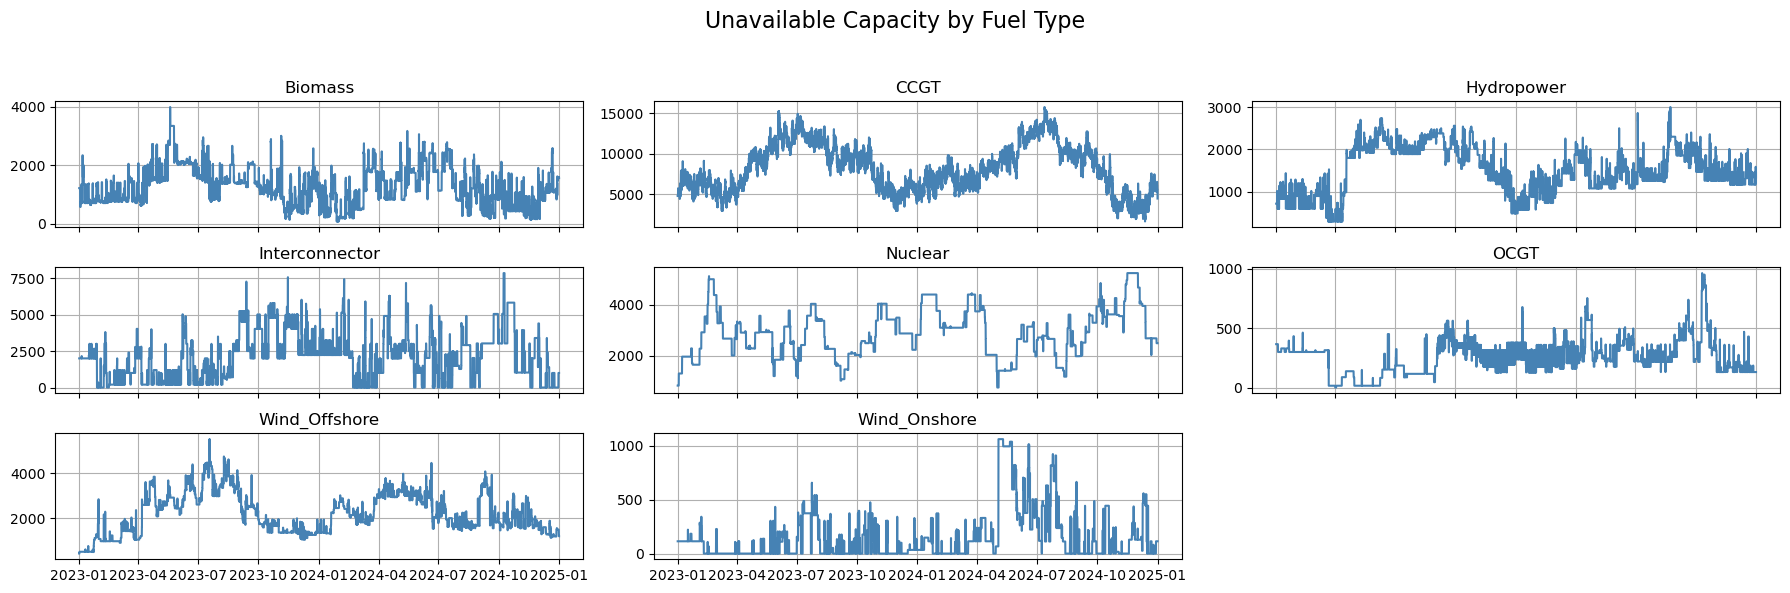

In [25]:
fuel_types = pivot_unavailable_capacity_per_fuel.columns 
num_fuels = len(fuel_types)

fig, axes = plt.subplots(nrows=(num_fuels + 2) // 3, ncols=3, figsize=(18, 2 * ((num_fuels + 2) // 3)), sharex=True)

axes = axes.flatten()

for i, fuel in enumerate(fuel_types):
    axes[i].plot(pivot_unavailable_capacity_per_fuel.index, pivot_unavailable_capacity_per_fuel[fuel], label=fuel, color='steelblue')
    axes[i].set_title(fuel)
    axes[i].grid(True)

for ax in axes[num_fuels:]:
    ax.set_visible(False)

plt.suptitle('Unavailable Capacity by Fuel Type', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

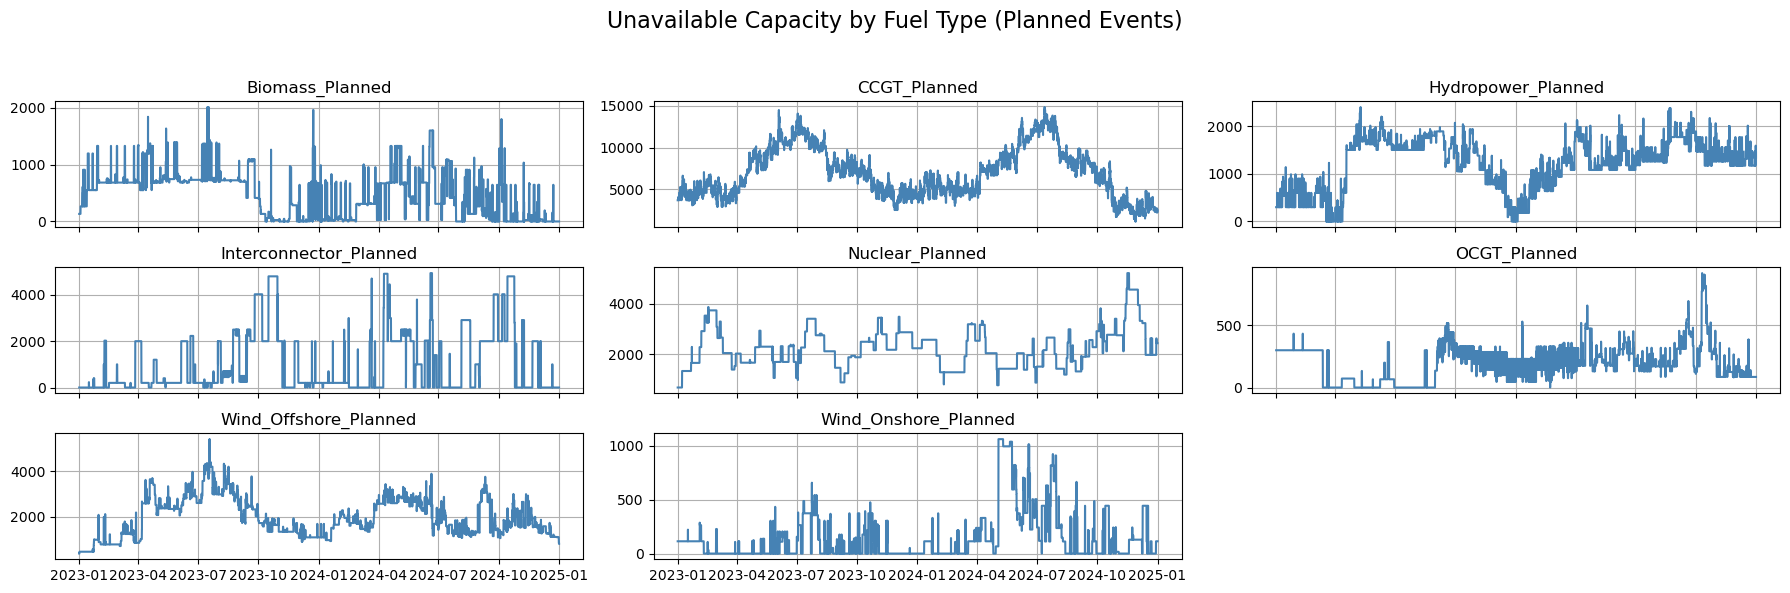

In [26]:
fuel_types = pivot_unavailable_capacity_per_fuel_planned.columns 
num_fuels = len(fuel_types)

fig, axes = plt.subplots(nrows=(num_fuels + 2) // 3, ncols=3, figsize=(18, 2 * ((num_fuels + 2) // 3)), sharex=True)

axes = axes.flatten()

for i, fuel in enumerate(fuel_types):
    axes[i].plot(pivot_unavailable_capacity_per_fuel_planned.index, pivot_unavailable_capacity_per_fuel_planned[fuel], label=fuel, color='steelblue')
    axes[i].set_title(fuel)
    axes[i].grid(True)

for ax in axes[num_fuels:]:
    ax.set_visible(False)

plt.suptitle('Unavailable Capacity by Fuel Type (Planned Events)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

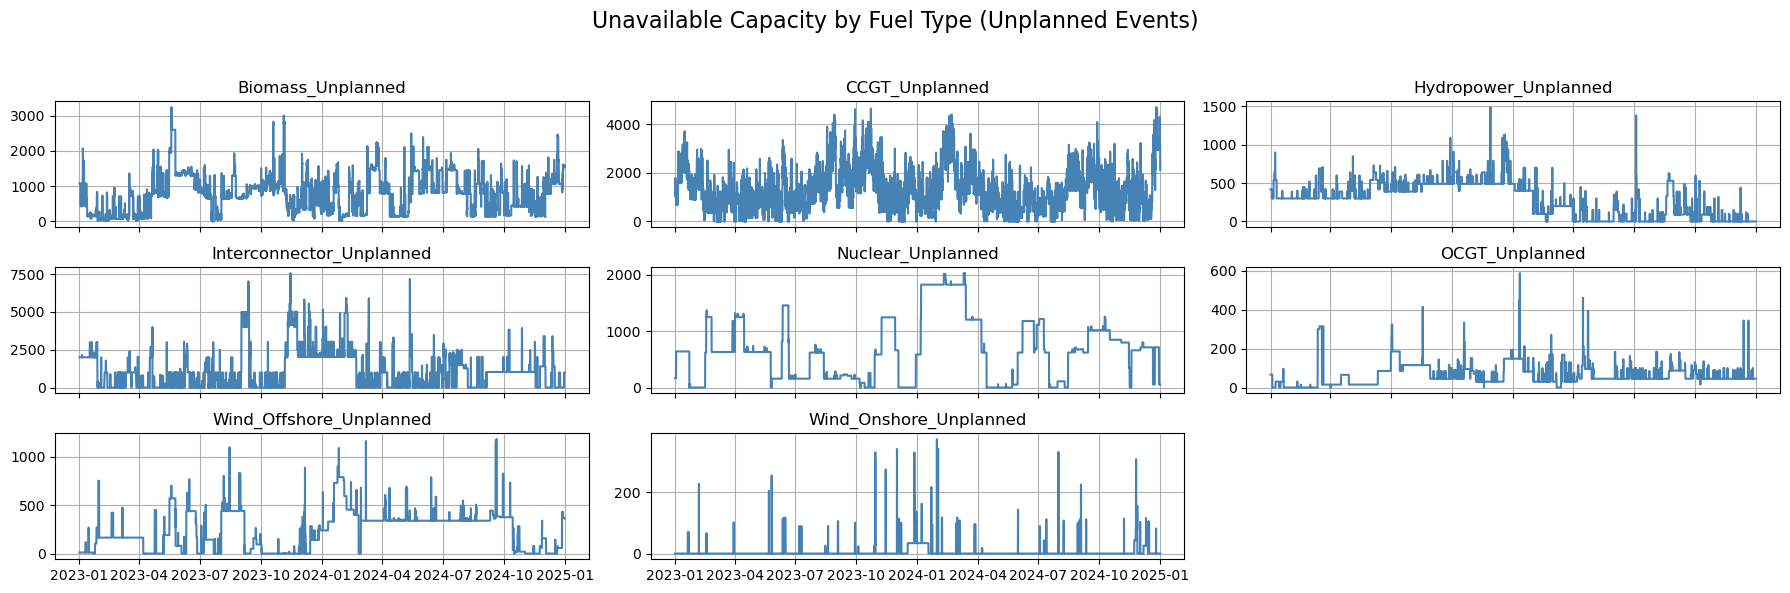

In [27]:
fuel_types = pivot_unavailable_capacity_per_fuel_unplanned.columns 
num_fuels = len(fuel_types)

fig, axes = plt.subplots(nrows=(num_fuels + 2) // 3, ncols=3, figsize=(18, 2 * ((num_fuels + 2) // 3)), sharex=True)

axes = axes.flatten()

for i, fuel in enumerate(fuel_types):
    axes[i].plot(pivot_unavailable_capacity_per_fuel_unplanned.index, pivot_unavailable_capacity_per_fuel_unplanned[fuel], label=fuel, color='steelblue')
    axes[i].set_title(fuel)
    axes[i].grid(True)

for ax in axes[num_fuels:]:
    ax.set_visible(False)

plt.suptitle('Unavailable Capacity by Fuel Type (Unplanned Events)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

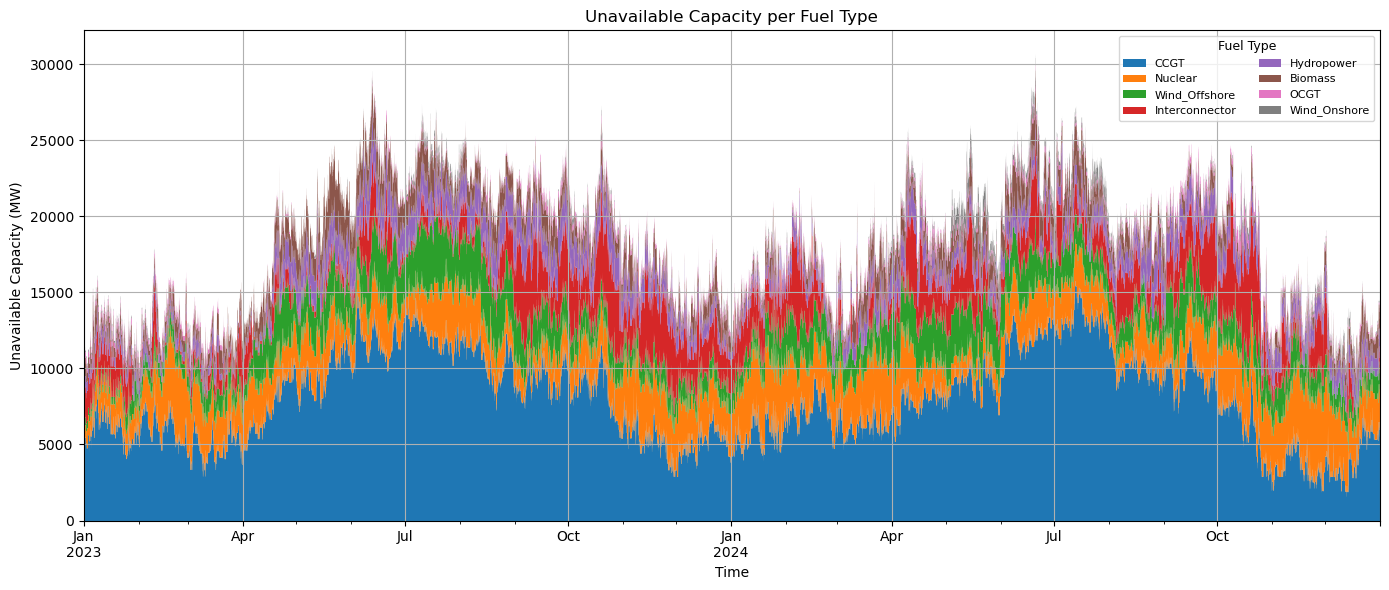

In [28]:
import matplotlib.pyplot as plt

# --- Compute average unavailable capacity for each fuel type ---
average_unavailable = pivot_unavailable_capacity_per_fuel.mean().sort_values(ascending=False)

# --- Ensure 'CCGT' is first, then sort rest ---
fuel_types_ordered = ['CCGT'] + [ft for ft in average_unavailable.index if ft != 'CCGT']
pivot_df_ordered = pivot_unavailable_capacity_per_fuel[fuel_types_ordered]

# --- Match colors to ordered columns ---
colors = [fuel_colors[ft] for ft in pivot_df_ordered.columns]

# --- Plot ---
pivot_df_ordered.fillna(0).plot(
    kind='area',
    stacked=True,
    figsize=(14, 6),
    linewidth=0,
    color=colors
)

plt.title('Unavailable Capacity per Fuel Type')
plt.xlabel('Time')
plt.ylabel('Unavailable Capacity (MW)')

# Legend with smaller font & two columns
plt.legend(
    title='Fuel Type',
    loc='upper right',
    ncol=2,
    fontsize=8,       # Smaller legend text
    title_fontsize=9  # Smaller legend title
)

plt.tight_layout()
plt.grid(True)
plt.show()

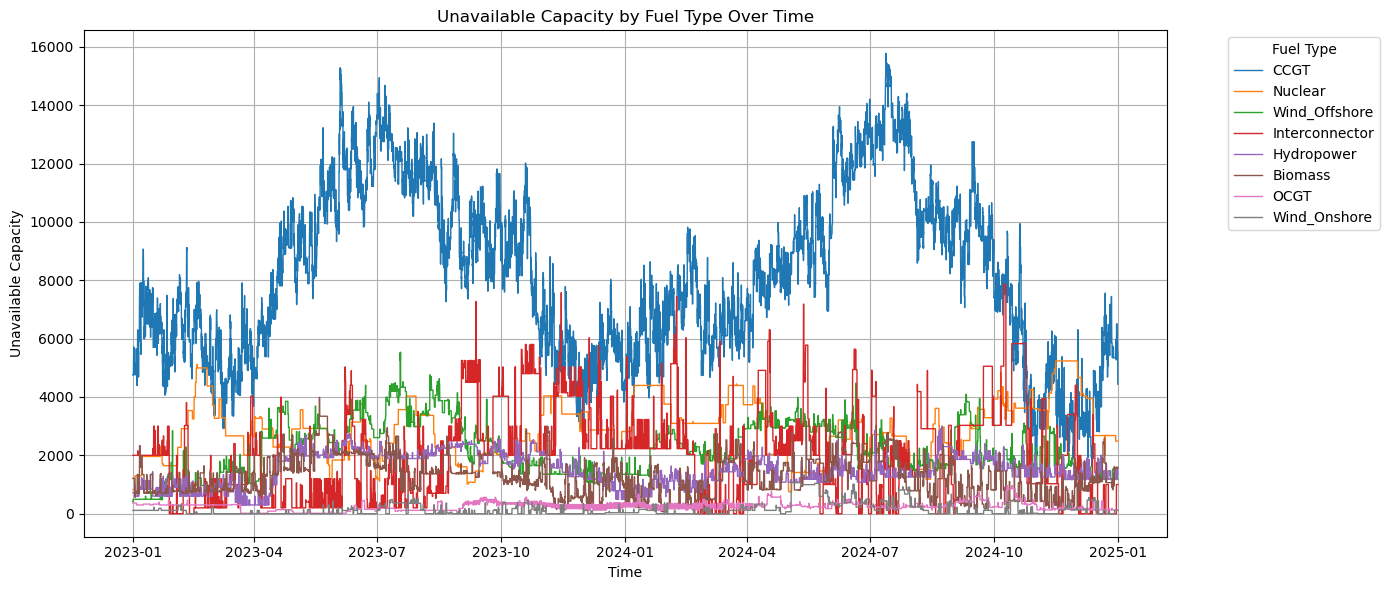

In [29]:
import matplotlib.pyplot as plt

# Compute average unavailable capacity for each fuel type
average_unavailable = pivot_unavailable_capacity_per_fuel.mean().sort_values(ascending=False)

# Ensure 'Fossil Gas' is first, then sort the rest (excluding Fossil Gas)
fuel_types_ordered = ['CCGT'] + [ft for ft in average_unavailable.index if ft != 'CCGT']

# Reorder pivot_df columns accordingly
pivot_df_ordered = pivot_unavailable_capacity_per_fuel[fuel_types_ordered]

# Plotting
plt.figure(figsize=(14, 6))

# Plot each fuel type in order
for column in fuel_types_ordered:
    plt.plot(pivot_df_ordered.index, pivot_df_ordered[column], label=column, linewidth=1)

plt.xlabel('Time')
plt.ylabel('Unavailable Capacity')
plt.title('Unavailable Capacity by Fuel Type Over Time')
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Same order as plotted
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Group by StartTime and unavailabilityType across all fuel types
grouped_by_unavailability = (
    unit_capacity_over_time.groupby(['StartTime', 'unavailabilityType'])['unavailableCapacity']
    .sum()
    .reset_index()
)

# Pivot so that each unavailabilityType is a column
pivot_by_unavailability_type = grouped_by_unavailability.pivot(
    index='StartTime',
    columns='unavailabilityType',
    values='unavailableCapacity'
)

In [31]:
# Combining both datasets into one dataframe
pivot_capacity_per_fuel_planned_and_unplanned = (
    pivot_capacity_per_fuel_planned_and_unplanned
    .merge(
        pivot_by_unavailability_type,
        left_index=True,
        right_index=True
    )
    .sort_index()
    .reset_index(drop=False)
)

# Set StartTime as the index
pivot_capacity_per_fuel_planned_and_unplanned.set_index('StartTime', inplace=True)

# Rename columns
pivot_capacity_per_fuel_planned_and_unplanned.rename(
    columns={
        'Planned': 'Planned_Unavailability',
        'Unplanned': 'Unplanned_Unavailability'
    },
    inplace=True
)

# Create new column as the sum of the two
pivot_capacity_per_fuel_planned_and_unplanned['Total_Unavailability'] = (
    pivot_capacity_per_fuel_planned_and_unplanned['Planned_Unavailability'] +
    pivot_capacity_per_fuel_planned_and_unplanned['Unplanned_Unavailability']
)

# View dataframe
pivot_capacity_per_fuel_planned_and_unplanned

Biomass_Planned  CCGT_Planned  Hydropower_Planned  \
StartTime                                                                
2023-01-01 00:00:00            133.0        3693.4               300.0   
2023-01-01 00:30:00            133.0        3693.4               300.0   
2023-01-01 01:00:00            133.0        3693.4               300.0   
2023-01-01 01:30:00            133.0        3693.4               300.0   
2023-01-01 02:00:00            133.0        3693.4               300.0   
...                              ...           ...                 ...   
2024-12-31 21:30:00              0.0        2596.0              1470.0   
2024-12-31 22:00:00              0.0        2596.0              1470.0   
2024-12-31 22:30:00              0.0        2596.0              1470.0   
2024-12-31 23:00:00              0.0        2329.0              1470.0   
2024-12-31 23:30:00              0.0        2329.0              1340.0   

                     Interconnector_Planned  Nuclear_Planned  OCGT_Planned  \
StartTime                                                                    
2023-01-01 00:00:00                     0.0            661.0         299.0   
2023-01-01 00:30:00                     0.0            661.0         299.0   
2023-01-01 01:00:00                     0.0            661.0         299.0   
2023-01-01 01:30:00                     0.0            661.0         299.0   
2023-01-01 02:00:00                     0.0            661.0         299.0   
...                                     ...              ...           ...   
2024-12-31 21:30:00                     0.0           2435.0          85.0   
2024-12-31 22:00:00                     0.0           2435.0          85.0   
2024-12-31 22:30:00                     0.0           2435.0          85.0   
2024-12-31 23:00:00                     0.0           2435.0          85.0   
2024-12-31 23:30:00                     0.0           2435.0          85.0   

                     Wind_Offshore_Planned  Wind_Onshore_Planned  \
StartTime                                                          
2023-01-01 00:00:00                  404.0                 114.0   
2023-01-01 00:30:00                  404.0                 114.0   
2023-01-01 01:00:00                  404.0                 114.0   
2023-01-01 01:30:00                  404.0                 114.0   
2023-01-01 02:00:00                  404.0                 114.0   
...                                    ...                   ...   
2024-12-31 21:30:00                  825.6                 114.0   
2024-12-31 22:00:00                  825.6                 114.0   
2024-12-31 22:30:00                  825.6                 114.0   
2024-12-31 23:00:00                  825.6                 114.0   
2024-12-31 23:30:00                  825.6                 114.0   

                     Biomass_Unplanned  CCGT_Unplanned  Hydropower_Unplanned  \
StartTime                                                                      
2023-01-01 00:00:00             1078.0          1060.0                 420.0   
2023-01-01 00:30:00             1078.0          1060.0                 420.0   
2023-01-01 01:00:00             1078.0          1060.0                 420.0   
2023-01-01 01:30:00             1078.0          1060.0                 420.0   
2023-01-01 02:00:00             1078.0          1060.0                 420.0   
...                                ...             ...                   ...   
2024-12-31 21:30:00             1554.0          2941.0                   0.0   
2024-12-31 22:00:00             1554.0          2941.0                   0.0   
2024-12-31 22:30:00             1554.0          2941.0                   0.0   
2024-12-31 23:00:00             1554.0          2109.0                   0.0   
2024-12-31 23:30:00             1554.0          2109.0                   0.0   

                     Interconnector_Unplanned  Nuclear_Unplanned  \
StartTime                                        

In [32]:
# Save dataframe
pivot_capacity_per_fuel_planned_and_unplanned.to_csv('REMIT_Unavailable_Capacity_By_FuelType_And_Availability_Type.csv')

<Figure size 1400x600 with 0 Axes>

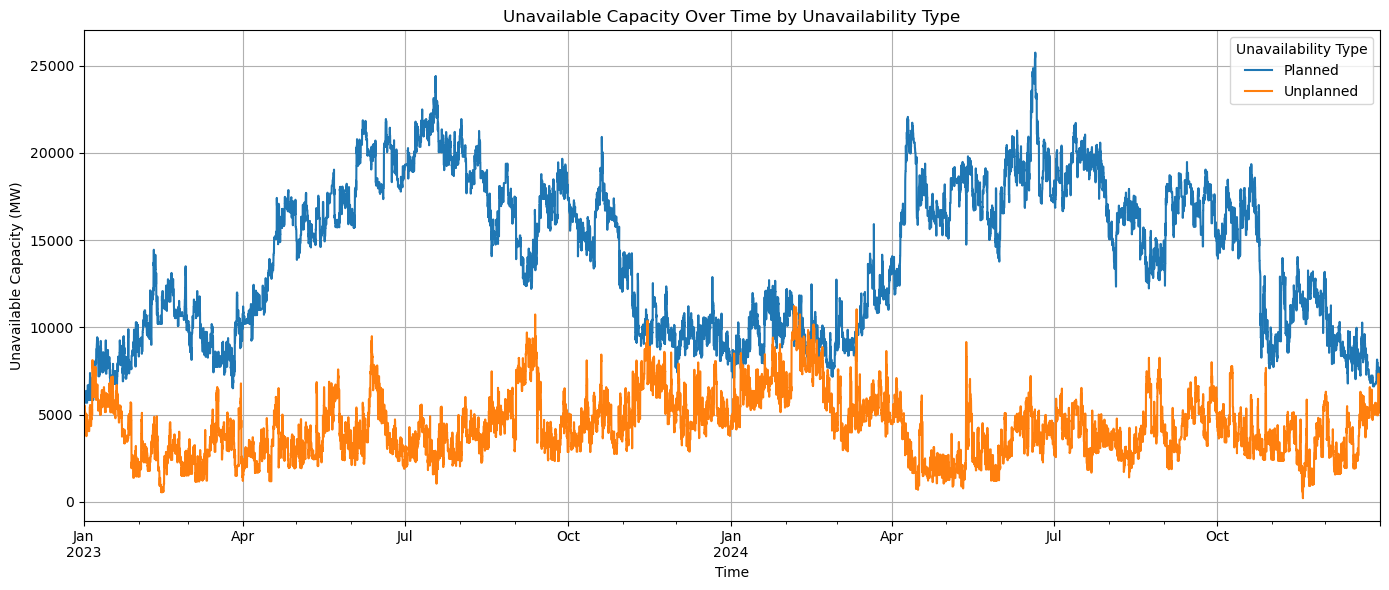

In [33]:
plt.figure(figsize=(14, 6))
pivot_by_unavailability_type.plot(
    figsize=(14, 6),
    title='Unavailable Capacity Over Time by Unavailability Type',
    xlabel='Time',
    ylabel='Unavailable Capacity (MW)',
    grid=True
)

plt.legend(title='Unavailability Type')
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

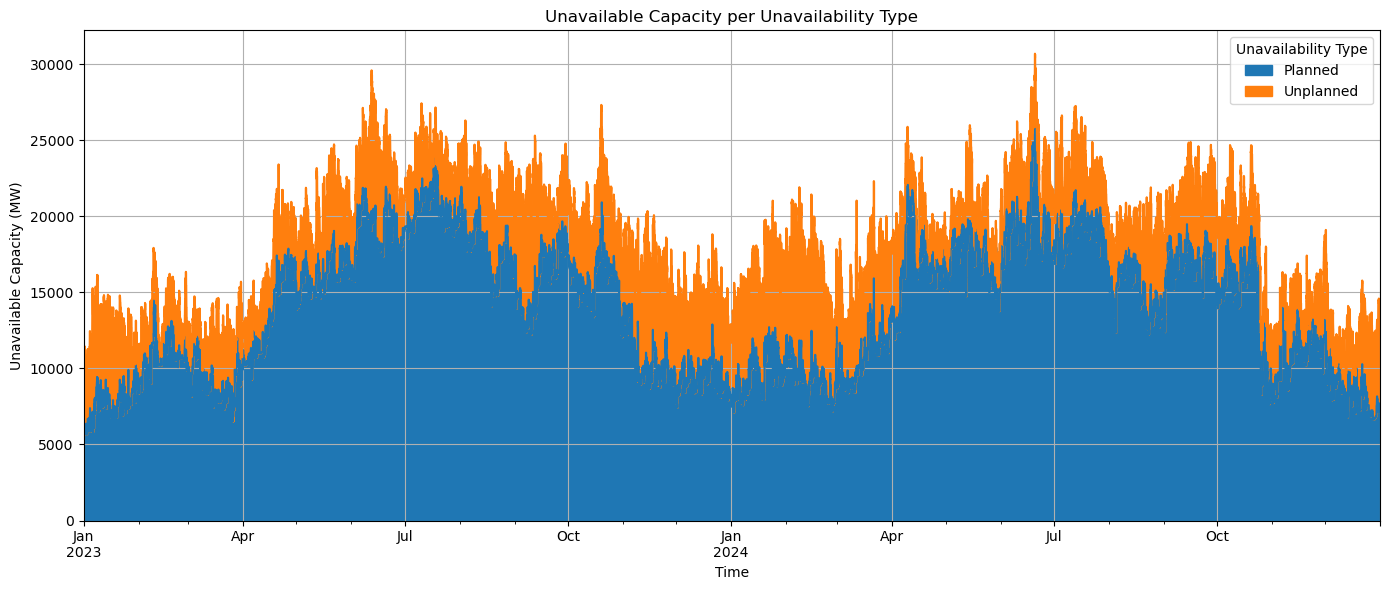

In [34]:
plt.figure(figsize=(14, 6))
pivot_by_unavailability_type.plot.area(
    figsize=(14, 6),
    title='Unavailable Capacity per Unavailability Type',
    xlabel='Time',
    ylabel='Unavailable Capacity (MW)',
    stacked=True,
    grid=True
)

plt.legend(title='Unavailability Type')
plt.tight_layout()
plt.show()

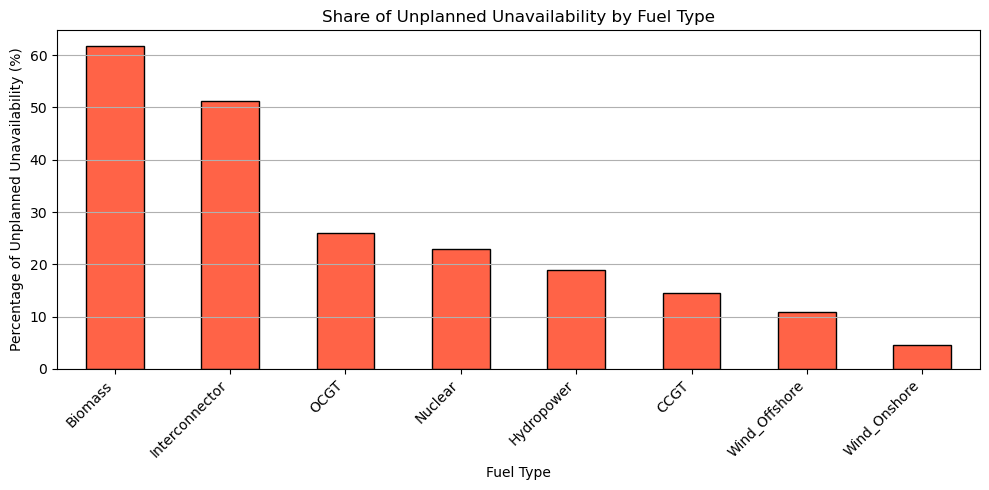

In [35]:
# Step 1: Group by fuelType and unavailabilityType, summing unavailableCapacity
grouped = unit_capacity_over_time.groupby(['fuelType', 'unavailabilityType'])['unavailableCapacity'].sum().unstack(fill_value=0)

# Step 2: Calculate total and unplanned percentage
grouped['Total'] = grouped.sum(axis=1)
grouped['Unplanned %'] = (grouped.get('Unplanned', 0) / grouped['Total']) * 100

# Step 3: Plot sorted bar chart
grouped['Unplanned %'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 5),
    color='tomato',
    edgecolor='black'
)

plt.ylabel('Percentage of Unplanned Unavailability (%)')
plt.xlabel('Fuel Type')
plt.title('Share of Unplanned Unavailability by Fuel Type')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

C:\Users\rocco\AppData\Local\Temp\ipykernel_14160\3199911369.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


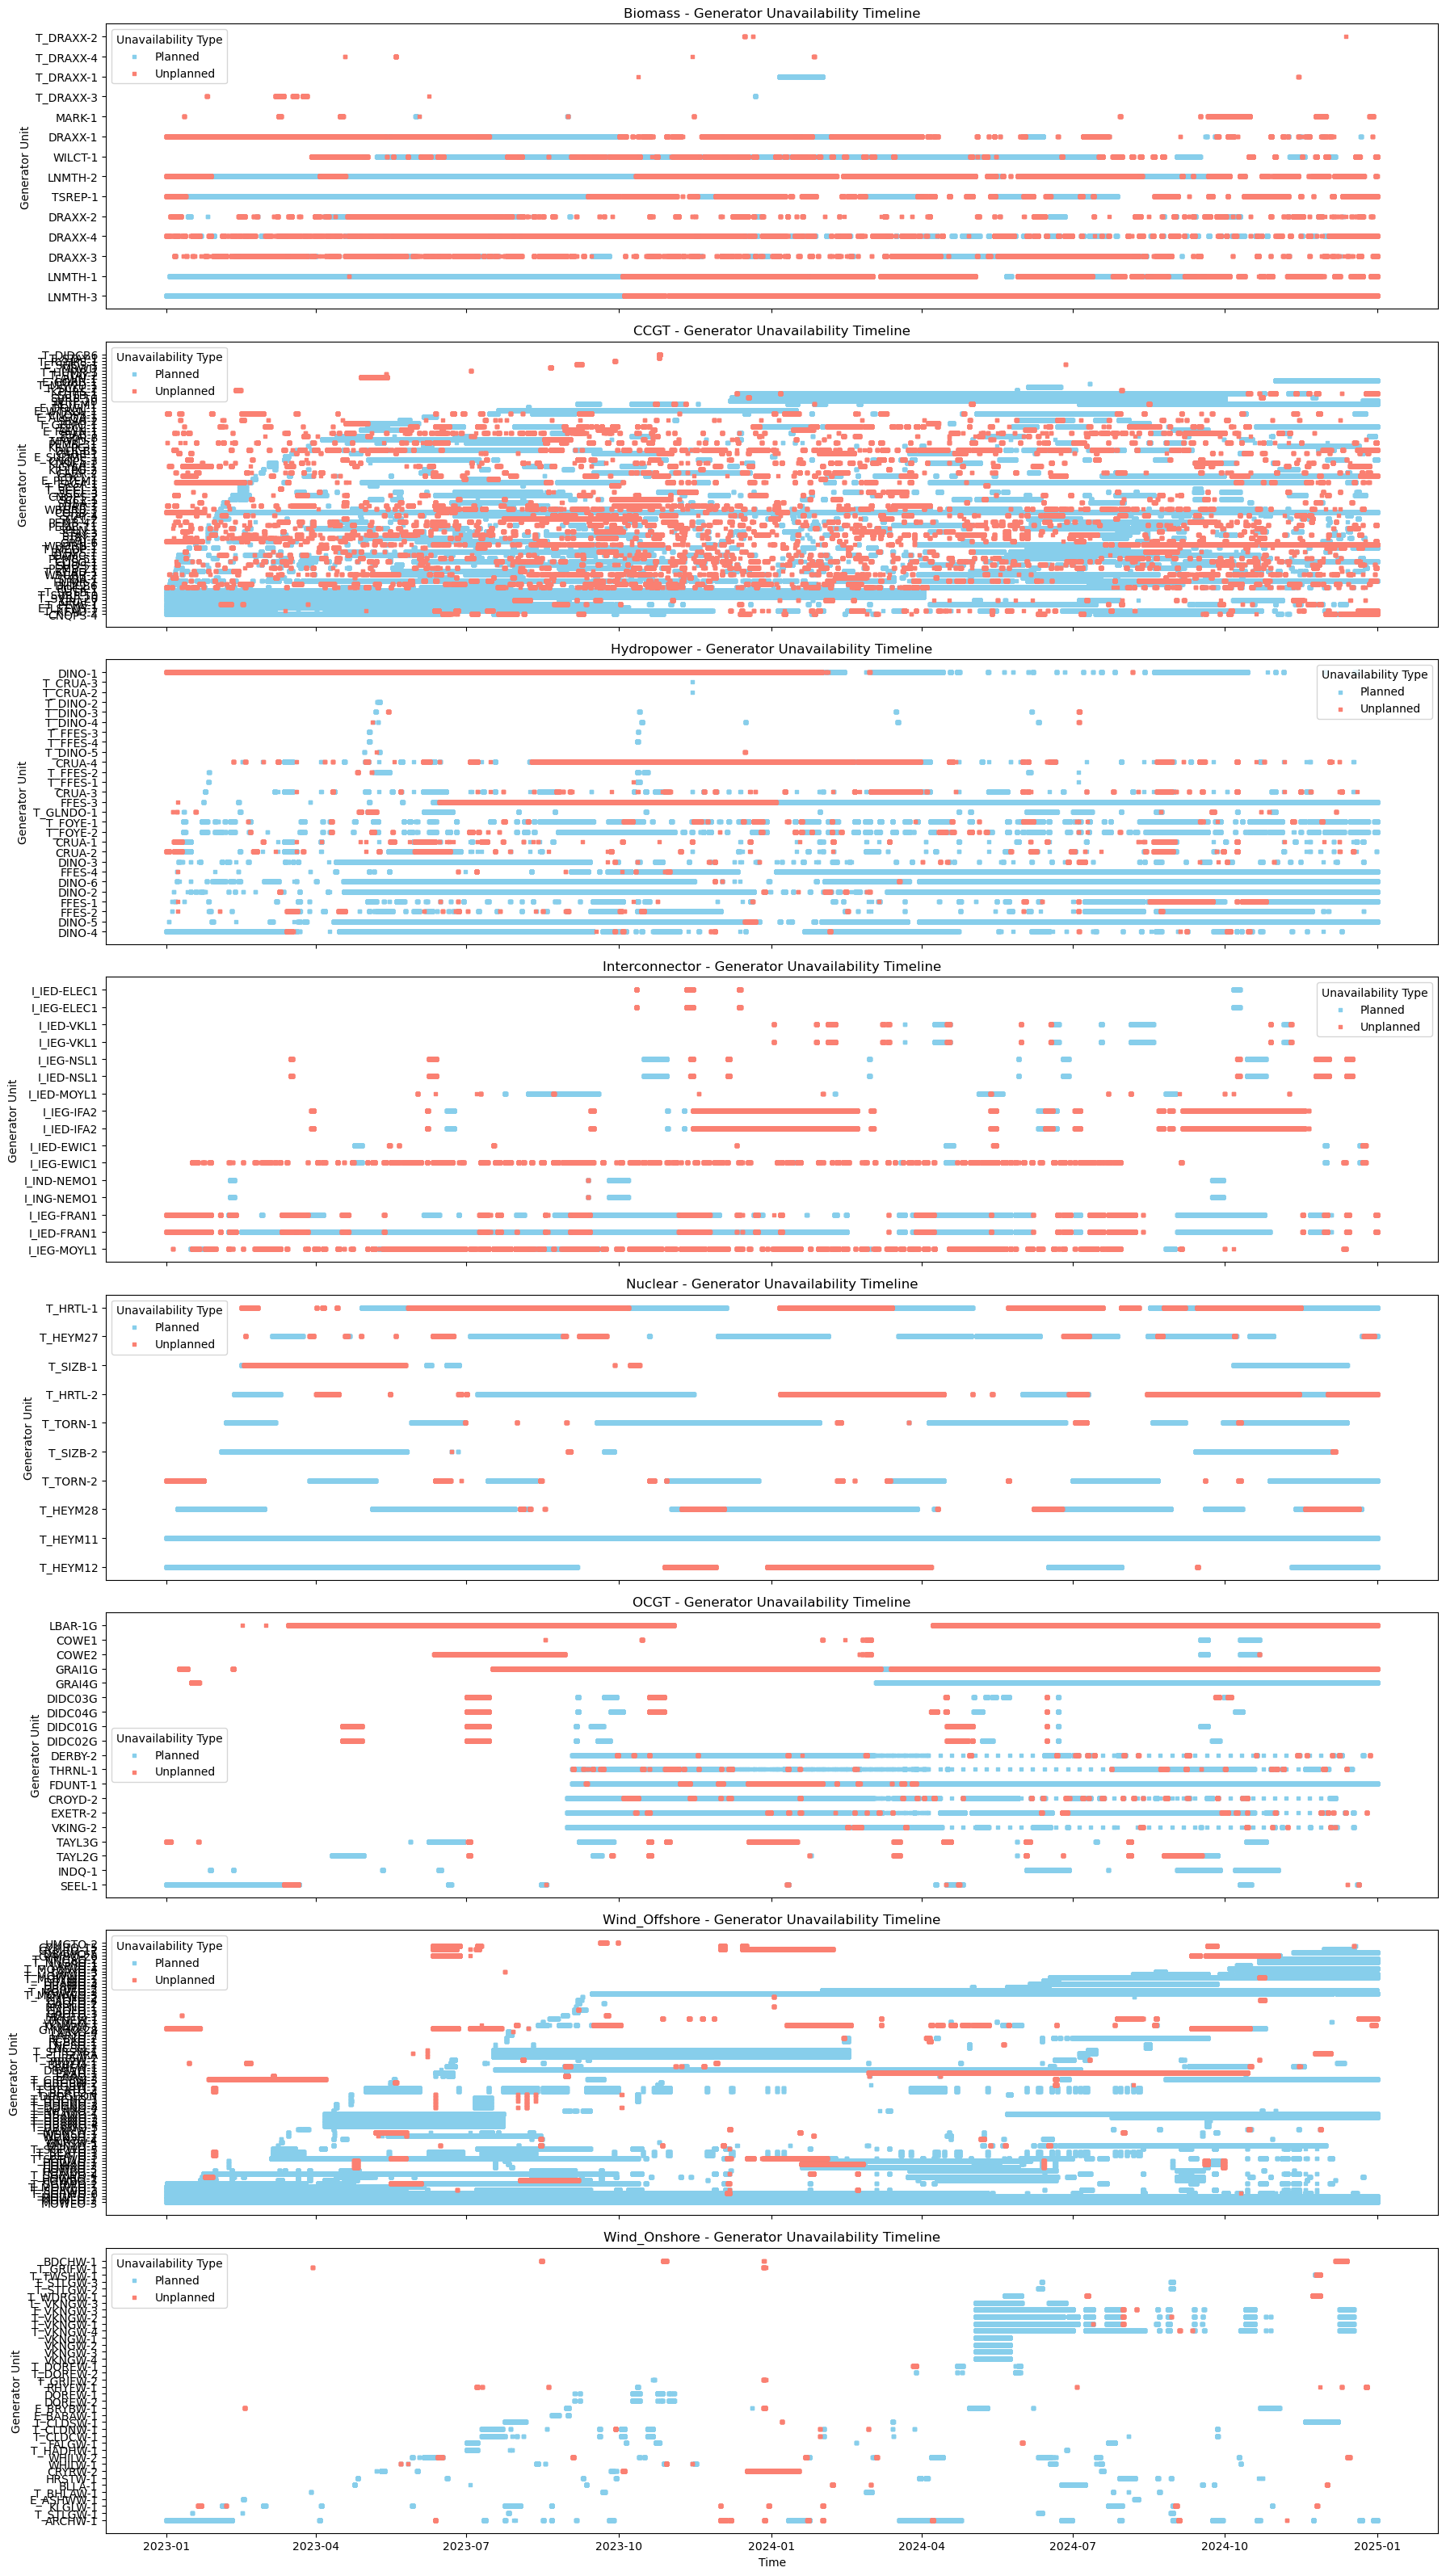

In [36]:
# Step 1: Mark entries where capacity is unavailable
df_plot = unit_capacity_over_time[unit_capacity_over_time['unavailableCapacity'] > 0].copy()

# Step 2: Get sorted list of unique fuel types
fuel_types = sorted(df_plot['fuelType'].dropna().unique())

# Step 3: Define color mapping
color_map = {'Planned': 'skyblue', 'Unplanned': 'salmon'}

# Step 4: Create subplots (1 per fuel type)
n_fuels = len(fuel_types)
fig, axes = plt.subplots(n_fuels, 1, figsize=(18, 4 * n_fuels), sharex=True)

if n_fuels == 1:
    axes = [axes]  # Ensure list if only 1 fuel type

# Step 5: Loop through each fuel type and plot affected units over time
for ax, fuel in zip(axes, fuel_types):
    fuel_df = df_plot[df_plot['fuelType'] == fuel].copy()

    # Set y-axis as sorted generator units
    unit_order = (
        fuel_df[['affectedUnit']]
        .drop_duplicates()
        .sort_values(by='affectedUnit')
    )

    fuel_df['affectedUnit'] = pd.Categorical(
        fuel_df['affectedUnit'],
        categories=unit_order['affectedUnit'],
        ordered=True
    )

    # Plot both planned and unplanned events
    for utype, color in color_map.items():
        subset = fuel_df[fuel_df['unavailabilityType'] == utype]
        ax.scatter(
            subset['StartTime'],
            subset['affectedUnit'],
            c=color,
            label=utype,
            marker='s',
            s=10
        )

    ax.set_title(f"{fuel} - Generator Unavailability Timeline")
    ax.set_ylabel("Generator Unit")
    ax.legend(title="Unavailability Type")
    ax.grid(False)

# X-axis label for the last plot only
axes[-1].set_xlabel("Time")

plt.tight_layout()
plt.show()

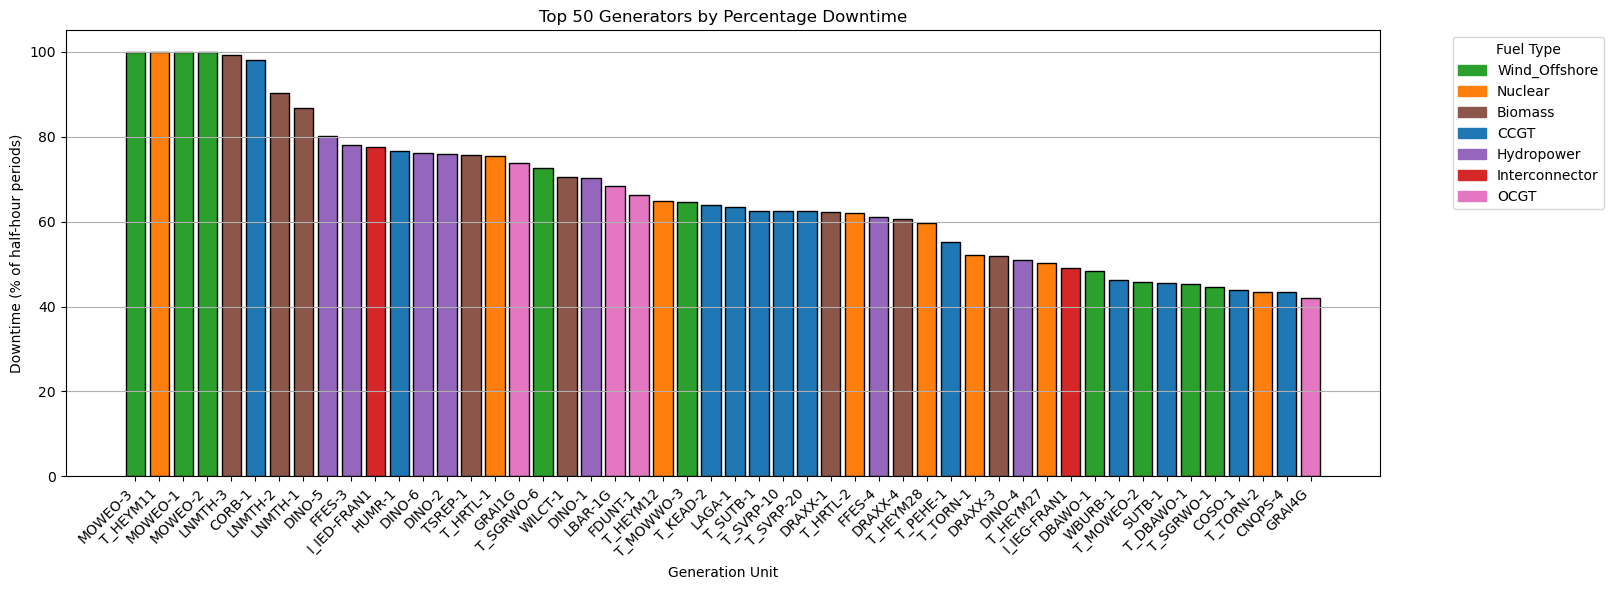

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Copy for safety
unit_capacity_over_time_v2 = unit_capacity_over_time.copy()

# Step 1: Aggregate by (affectedUnit, StartTime)
aggregated = (
    unit_capacity_over_time_v2
    .groupby(['affectedUnit', 'StartTime'])['unavailableCapacity']
    .sum()
    .reset_index()
)

# Step 2: Mark if unit is down
aggregated['is_down'] = aggregated['unavailableCapacity'] > 0

# Step 3: Calculate % downtime per unit
downtime_percent = (
    aggregated
    .groupby('affectedUnit')['is_down']
    .agg(['sum', 'count'])
    .assign(downtime_pct=lambda x: (x['sum'] / x['count']) * 100)
    .sort_values('downtime_pct', ascending=False)
)

# Step 4: Most common fuelType per unit
fuel_type_map = (
    unit_capacity_over_time_v2[['affectedUnit', 'fuelType']]
    .drop_duplicates()
    .groupby('affectedUnit')['fuelType']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

# Step 5: Merge fuel type
downtime_percent = downtime_percent.merge(fuel_type_map, on='affectedUnit', how='left')

# Step 6: Assign bar colors using your custom palette
top_n = 50
colors = downtime_percent.head(top_n)['fuelType'].map(fuel_colors)

# Step 7: Plot
plt.figure(figsize=(14, 6))
plt.bar(
    downtime_percent.head(top_n).index,
    downtime_percent.head(top_n)['downtime_pct'],
    color=colors,
    edgecolor='black'
)

plt.title(f'Top {top_n} Generators by Percentage Downtime')
plt.ylabel('Downtime (% of half-hour periods)')
plt.xlabel('Generation Unit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')

# Legend using only fuel types present in top N
top_fuels = downtime_percent.head(top_n)['fuelType'].unique()
handles = [plt.Rectangle((0, 0), 1, 1, color=fuel_colors[f]) for f in top_fuels]
plt.legend(handles, top_fuels, title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

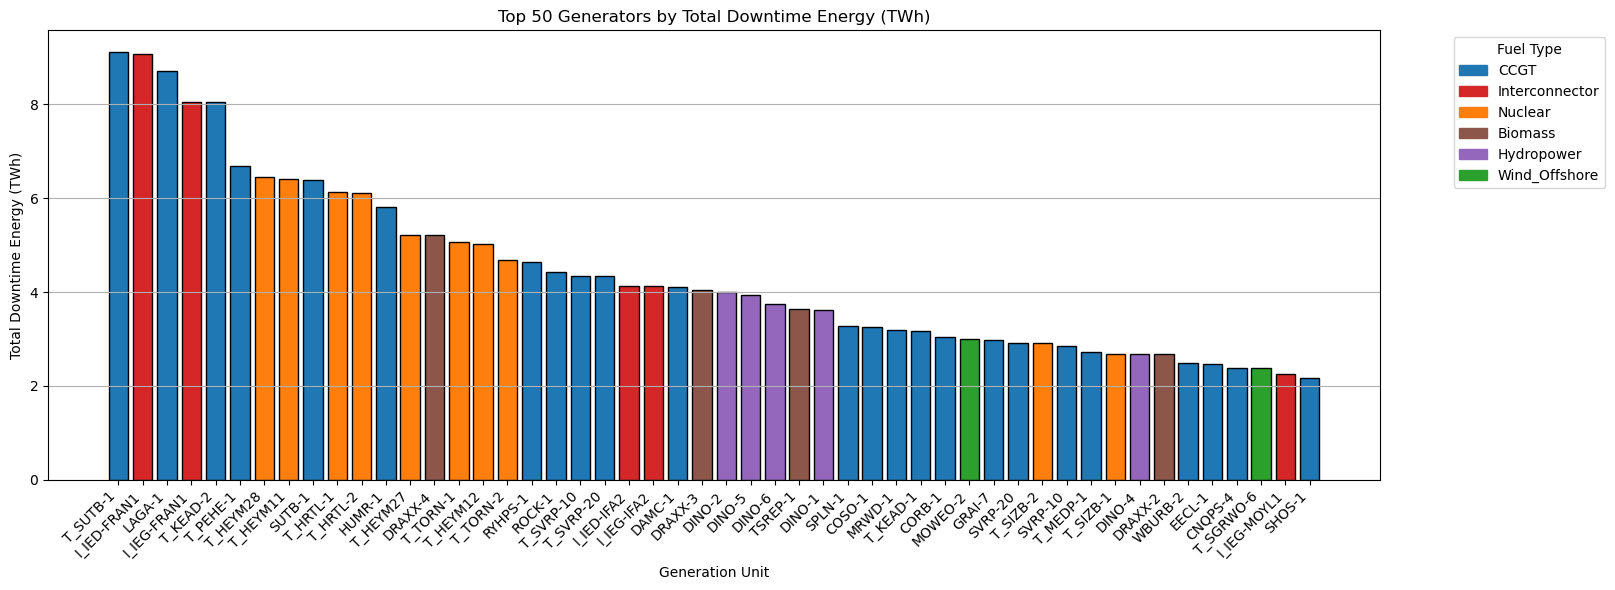

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Copy for safety
unit_capacity_over_time_v2 = unit_capacity_over_time.copy()

# Step 1: Aggregate by (affectedUnit, StartTime)
aggregated = (
    unit_capacity_over_time_v2
    .groupby(['affectedUnit', 'StartTime'])['unavailableCapacity']
    .sum()
    .reset_index()
)

# Step 2: Calculate MWh = unavailableCapacity × 0.5
aggregated['unavailableMWh'] = aggregated['unavailableCapacity'] * 0.5

# Step 3: Total MWh per generator
downtime_energy = (
    aggregated
    .groupby('affectedUnit')['unavailableMWh']
    .sum()
    .sort_values(ascending=False)
    .to_frame()
)

# Step 4: Convert to TWh
downtime_energy['unavailableTWh'] = downtime_energy['unavailableMWh'] / 1_000_000

# Step 5: Get most common fuelType per affectedUnit
fuel_type_map = (
    unit_capacity_over_time_v2[['affectedUnit', 'fuelType']]
    .drop_duplicates()
    .groupby('affectedUnit')['fuelType']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

# Step 6: Merge fuel type into downtime_energy
downtime_energy = downtime_energy.merge(fuel_type_map, on='affectedUnit', how='left')

# Step 7: Assign colors using your custom color scheme
top_n = 50
colors = downtime_energy.head(top_n)['fuelType'].map(fuel_colors)

# Step 8: Plot top N generators by total TWh downtime
plt.figure(figsize=(14, 6))
plt.bar(
    downtime_energy.head(top_n).index,
    downtime_energy.head(top_n)['unavailableTWh'],
    color=colors,
    edgecolor='black'
)

plt.title(f'Top {top_n} Generators by Total Downtime Energy (TWh)')
plt.ylabel('Total Downtime Energy (TWh)')
plt.xlabel('Generation Unit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')

# Legend only for fuel types present in top N
top_fuels = downtime_energy.head(top_n)['fuelType'].unique()
handles = [plt.Rectangle((0, 0), 1, 1, color=fuel_colors[f]) for f in top_fuels]
plt.legend(handles, top_fuels, title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [39]:
# Step 1: Work on a copy and ensure time format
df = unit_capacity_over_time.copy()
df['StartTime'] = pd.to_datetime(df['StartTime'])

# Step 2: Keep only rows with unavailability
df = df[df['unavailableCapacity'] > 0].copy()
df.sort_values(['affectedUnit', 'StartTime'], inplace=True)

# Step 3: Identify time gaps (more than 30 minutes between records)
df['time_diff'] = df.groupby('affectedUnit')['StartTime'].diff()
df['new_block'] = (df['time_diff'] != pd.Timedelta(minutes=30)).fillna(True)
df['block_id'] = df.groupby('affectedUnit')['new_block'].cumsum()

# Step 4: Group each outage block and summarize
grouped = df.groupby(['affectedUnit', 'block_id', 'fuelType', 'unavailabilityType'])
downtime_summary = grouped.agg(
    start_time=('StartTime', 'min'),
    end_time=('StartTime', 'max'),
    duration_half_hours=('StartTime', 'count'),
    avg_unavailable_capacity=('unavailableCapacity', 'mean')
).reset_index()

# Step 5: Convert duration to hours
downtime_summary['duration_hours'] = downtime_summary['duration_half_hours'] * 0.5

# Step 6: Final aggregation per fuel type & outage type
final_stats = downtime_summary.groupby(['fuelType', 'unavailabilityType']).agg(
    avg_duration_hours=('duration_hours', 'mean'),
    avg_capacity=('avg_unavailable_capacity', 'mean'),
    event_count=('block_id', 'count')
).reset_index()

# Display the result
final_stats

fuelType unavailabilityType  avg_duration_hours  avg_capacity  \
0          Biomass            Planned          234.386598    336.180565   
1          Biomass          Unplanned           73.033186    152.260667   
2             CCGT            Planned          178.665122    388.271817   
3             CCGT          Unplanned           20.026080    287.701698   
4       Hydropower            Planned          109.944568    168.894203   
5       Hydropower          Unplanned           85.899068    143.807453   
6   Interconnector            Planned          220.347619    874.986620   
7   Interconnector          Unplanned           39.680685    528.101257   
8          Nuclear            Planned         1269.043103    498.899825   
9          Nuclear          Unplanned          343.694444    218.422999   
10            OCGT            Planned           57.210556     50.215180   
11            OCGT          Unplanned          211.903614     55.427954   
12   Wind_Offshore            Planned          343.144917    181.212834   
13   Wind_Offshore          Unplanned          103.038647    110.392309   
14    Wind_Onshore            Planned           85.426829    128.361232   
15    Wind_Onshore          Unplanned           27.588235    110.512792   

    event_count  
0           194  
1           904  
2          1511  
3          3125  
4           902  
5           322  
6           105  
7           642  
8            58  
9            72  
10          881  
11          166  
12          659  
13          207  
14          246  
15           68

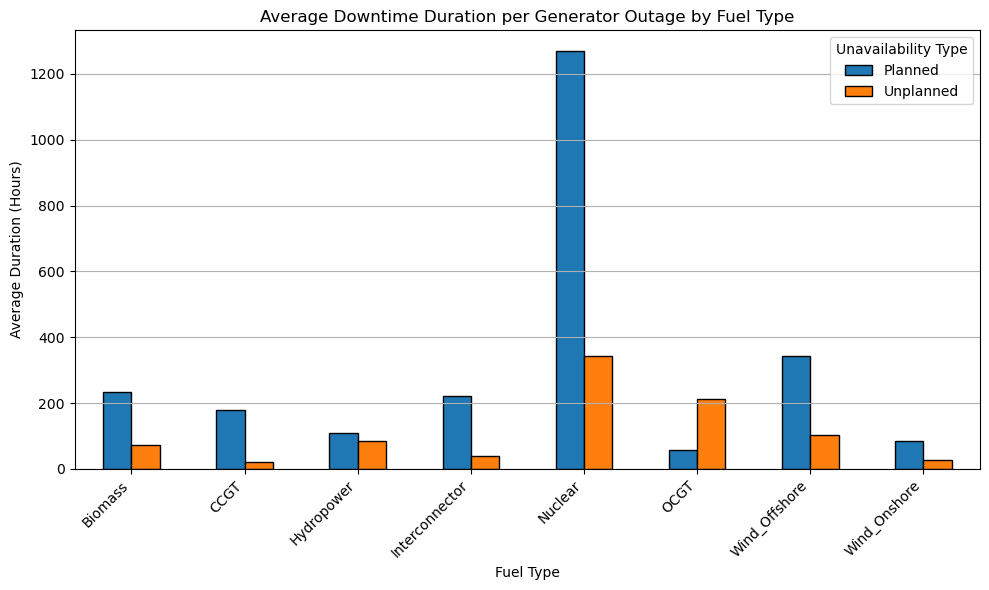

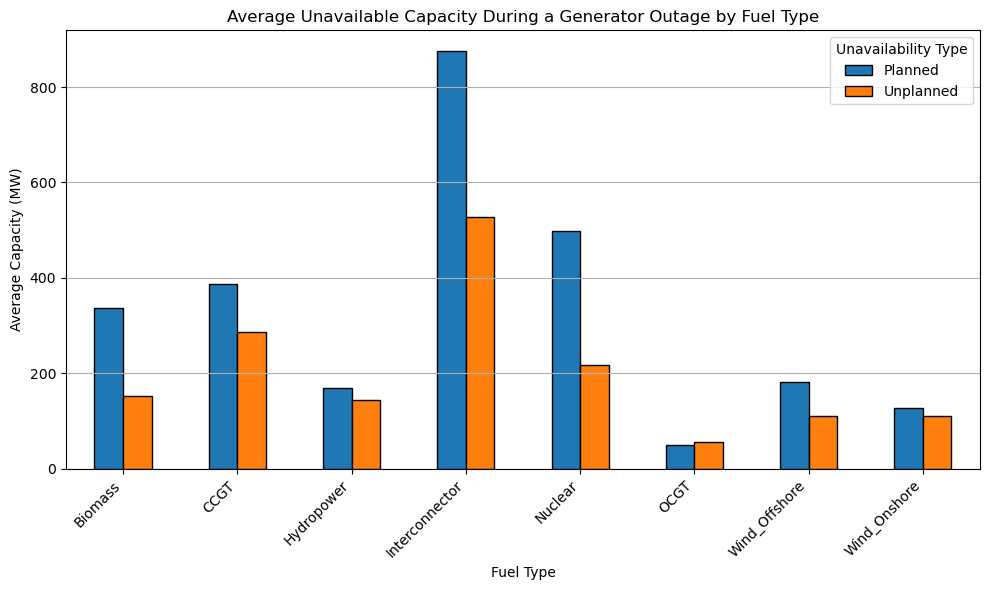

In [40]:
# Pivot for grouped bar chart
duration_pivot = final_stats.pivot(index='fuelType', columns='unavailabilityType', values='avg_duration_hours')
capacity_pivot = final_stats.pivot(index='fuelType', columns='unavailabilityType', values='avg_capacity')

# Plot 1: Average Downtime Duration
ax1 = duration_pivot.plot(kind='bar', figsize=(10, 6), edgecolor='black')
ax1.set_title('Average Downtime Duration per Generator Outage by Fuel Type')
ax1.set_ylabel('Average Duration (Hours)')
ax1.set_xlabel('Fuel Type')
ax1.legend(title='Unavailability Type')  # Add custom legend title
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot 2: Average Unavailable Capacity
ax2 = capacity_pivot.plot(kind='bar', figsize=(10, 6), edgecolor='black')
ax2.set_title('Average Unavailable Capacity During a Generator Outage by Fuel Type')
ax2.set_ylabel('Average Capacity (MW)')
ax2.set_xlabel('Fuel Type')
ax2.legend(title='Unavailability Type')  # Add custom legend title
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [41]:
# Dictionary of installed capacities by fuel type
installed_capacity_dict = {
    #'Fossil Oil': 1327,
    'OCGT': 5410,
    'Hydropower': 4790,
    'Biomass': 7637,
    'Nuclear': 5883,
    'CCGT': 31229,
    'Wind_Offshore': 15418,
    'Wind_Onshore': 14745,
    'Interconnector':20600,
    #'IC France 1': 4000,
    #'IC France 2': 2000,
    #'IC NEMO': 2000,
    #'IC East West': 1000,
    #'IC Eleclink': 2000,
    #'IC Moyle': 1000,
    #'IC Viking': 2800,
    #'IC North Sea': 2800,
    #'IC Netherlands': 2800,
    #'Battery': 4700,
    #'Coal': 4116  
}

# Create DataFrame
installed_capacity_df = pd.DataFrame(
    list(installed_capacity_dict.items()),
    columns=['fuelType', 'installedCapacity']
)

installed_capacity_df

fuelType  installedCapacity
0            OCGT               5410
1      Hydropower               4790
2         Biomass               7637
3         Nuclear               5883
4            CCGT              31229
5   Wind_Offshore              15418
6    Wind_Onshore              14745
7  Interconnector              20600

In [42]:
# Step 1: Set 'fuelType' as index in installed_capacity_df for alignment
installed_capacity_df = installed_capacity_df.set_index('fuelType')

# Step 2: Normalize and convert to percentage, then clip max to 100%
normalized_total = (pivot_unavailable_capacity_per_fuel / installed_capacity_df['installedCapacity']) * 100
normalized_total = normalized_total.clip(upper=100).fillna(0)

# Temporary column renaming: strip "_Planned" or "_Unplanned" for alignment
planned_cols = [col.replace('_Planned', '') for col in pivot_unavailable_capacity_per_fuel_planned.columns]
unplanned_cols = [col.replace('_Unplanned', '') for col in pivot_unavailable_capacity_per_fuel_unplanned.columns]

# Create copies with renamed columns for calculation
normalized_planned = (
    pivot_unavailable_capacity_per_fuel_planned.copy()
    .set_axis(planned_cols, axis=1)
    / installed_capacity_df['installedCapacity']
) * 100
normalized_planned = normalized_planned.clip(upper=100).fillna(0)

normalized_unplanned = (
    pivot_unavailable_capacity_per_fuel_unplanned.copy()
    .set_axis(unplanned_cols, axis=1)
    / installed_capacity_df['installedCapacity']
) * 100
normalized_unplanned = normalized_unplanned.clip(upper=100).fillna(0)

In [43]:
# Define each column with _Planned and _Unplanned suffixes
normalized_total.columns = [f"{col}_%" for col in normalized_total.columns]
normalized_planned.columns = [f"{col}_Planned_%" for col in normalized_planned.columns]
normalized_unplanned.columns = [f"{col}_Unplanned_%" for col in normalized_unplanned.columns]

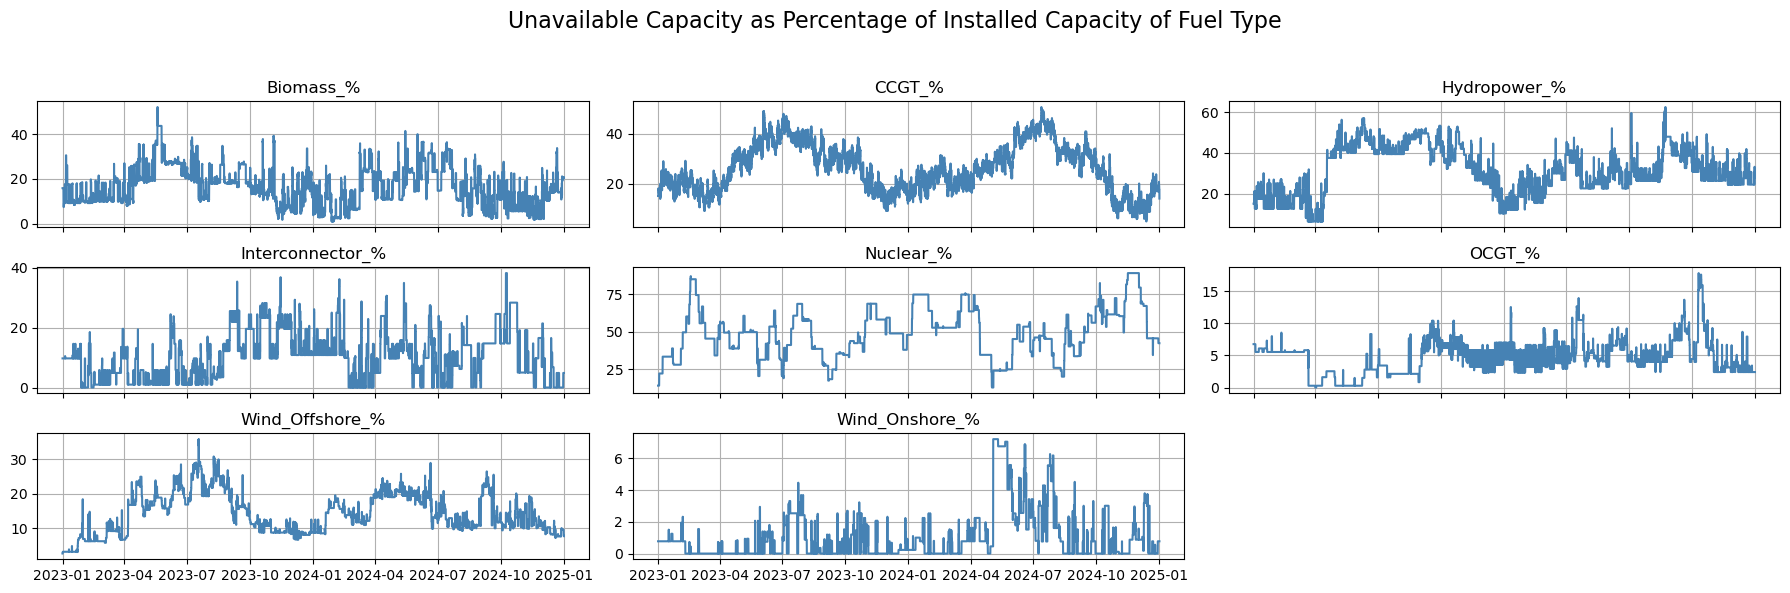

In [44]:
fuel_types = normalized_total.columns 
num_fuels = len(fuel_types)

fig, axes = plt.subplots(nrows=(num_fuels + 2) // 3, ncols=3, figsize=(18, 2 * ((num_fuels + 2) // 3)), sharex=True)

axes = axes.flatten()

for i, fuel in enumerate(fuel_types):
    axes[i].plot(normalized_total.index, normalized_total[fuel], label=fuel, color='steelblue')
    axes[i].set_title(fuel)
    axes[i].grid(True)

for ax in axes[num_fuels:]:
    ax.set_visible(False)

plt.suptitle('Unavailable Capacity as Percentage of Installed Capacity of Fuel Type', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

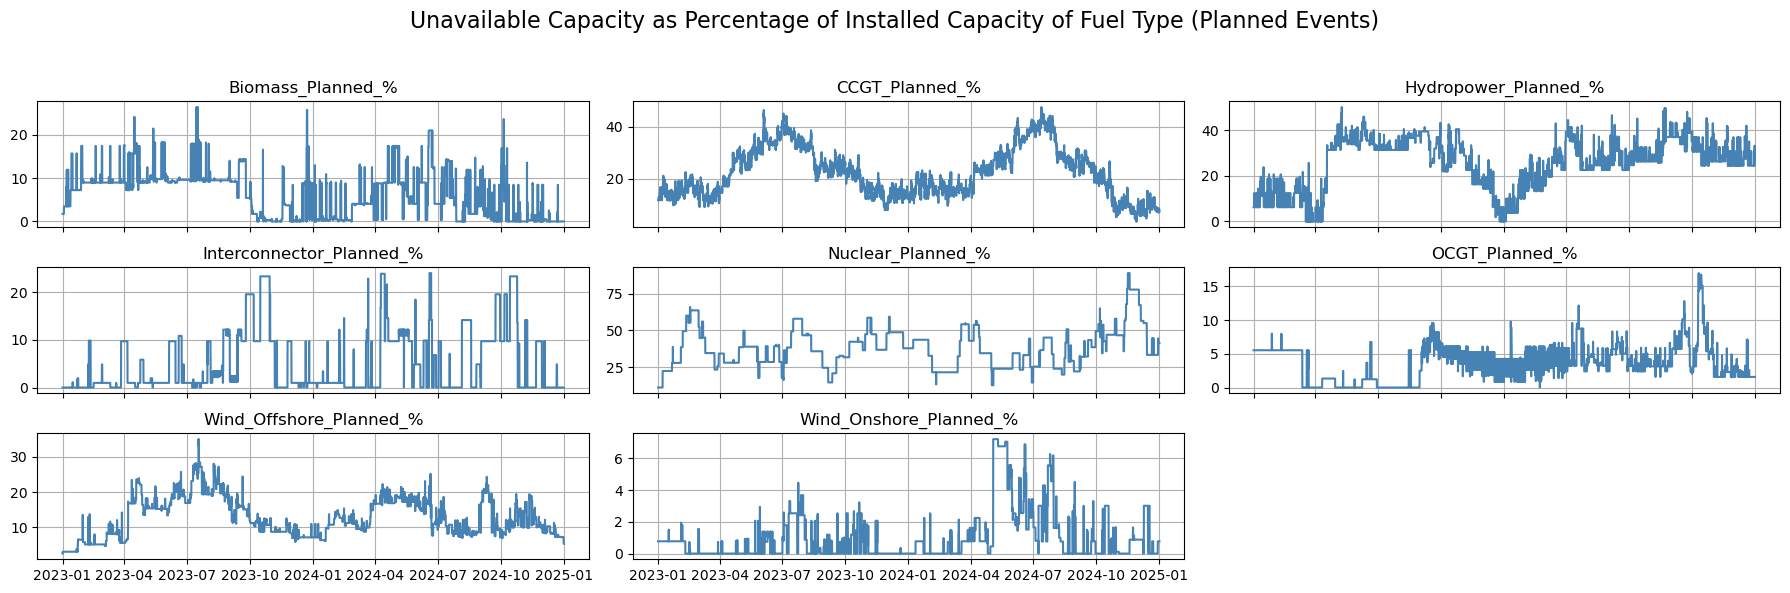

In [45]:
fuel_types = normalized_planned.columns 
num_fuels = len(fuel_types)

fig, axes = plt.subplots(nrows=(num_fuels + 2) // 3, ncols=3, figsize=(18, 2 * ((num_fuels + 2) // 3)), sharex=True)

axes = axes.flatten()

for i, fuel in enumerate(fuel_types):
    axes[i].plot(normalized_planned.index, normalized_planned[fuel], label=fuel, color='steelblue')
    axes[i].set_title(fuel)
    axes[i].grid(True)

for ax in axes[num_fuels:]:
    ax.set_visible(False)

plt.suptitle('Unavailable Capacity as Percentage of Installed Capacity of Fuel Type (Planned Events)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

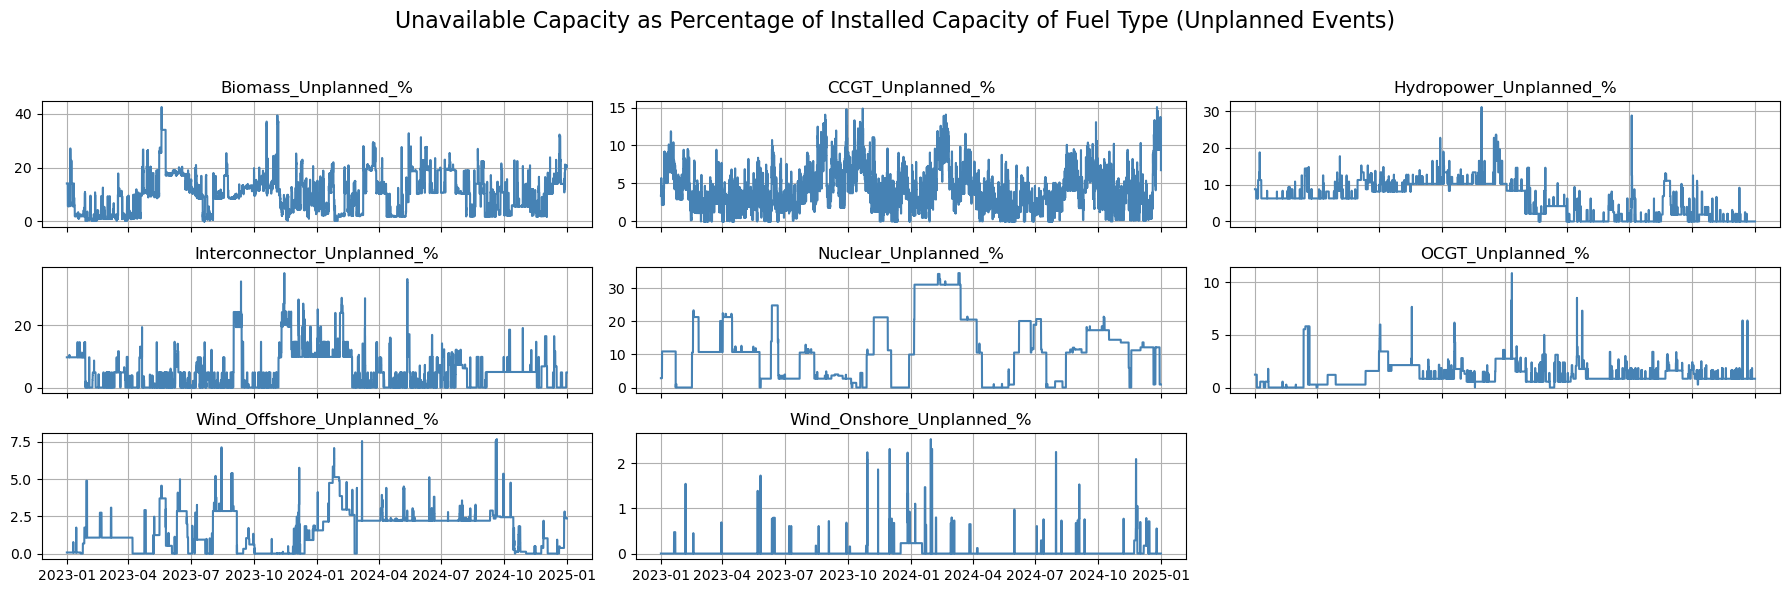

In [46]:
fuel_types = normalized_unplanned.columns 
num_fuels = len(fuel_types)

fig, axes = plt.subplots(nrows=(num_fuels + 2) // 3, ncols=3, figsize=(18, 2 * ((num_fuels + 2) // 3)), sharex=True)

axes = axes.flatten()

for i, fuel in enumerate(fuel_types):
    axes[i].plot(normalized_unplanned.index, normalized_unplanned[fuel], label=fuel, color='steelblue')
    axes[i].set_title(fuel)
    axes[i].grid(True)

for ax in axes[num_fuels:]:
    ax.set_visible(False)

plt.suptitle('Unavailable Capacity as Percentage of Installed Capacity of Fuel Type (Unplanned Events)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

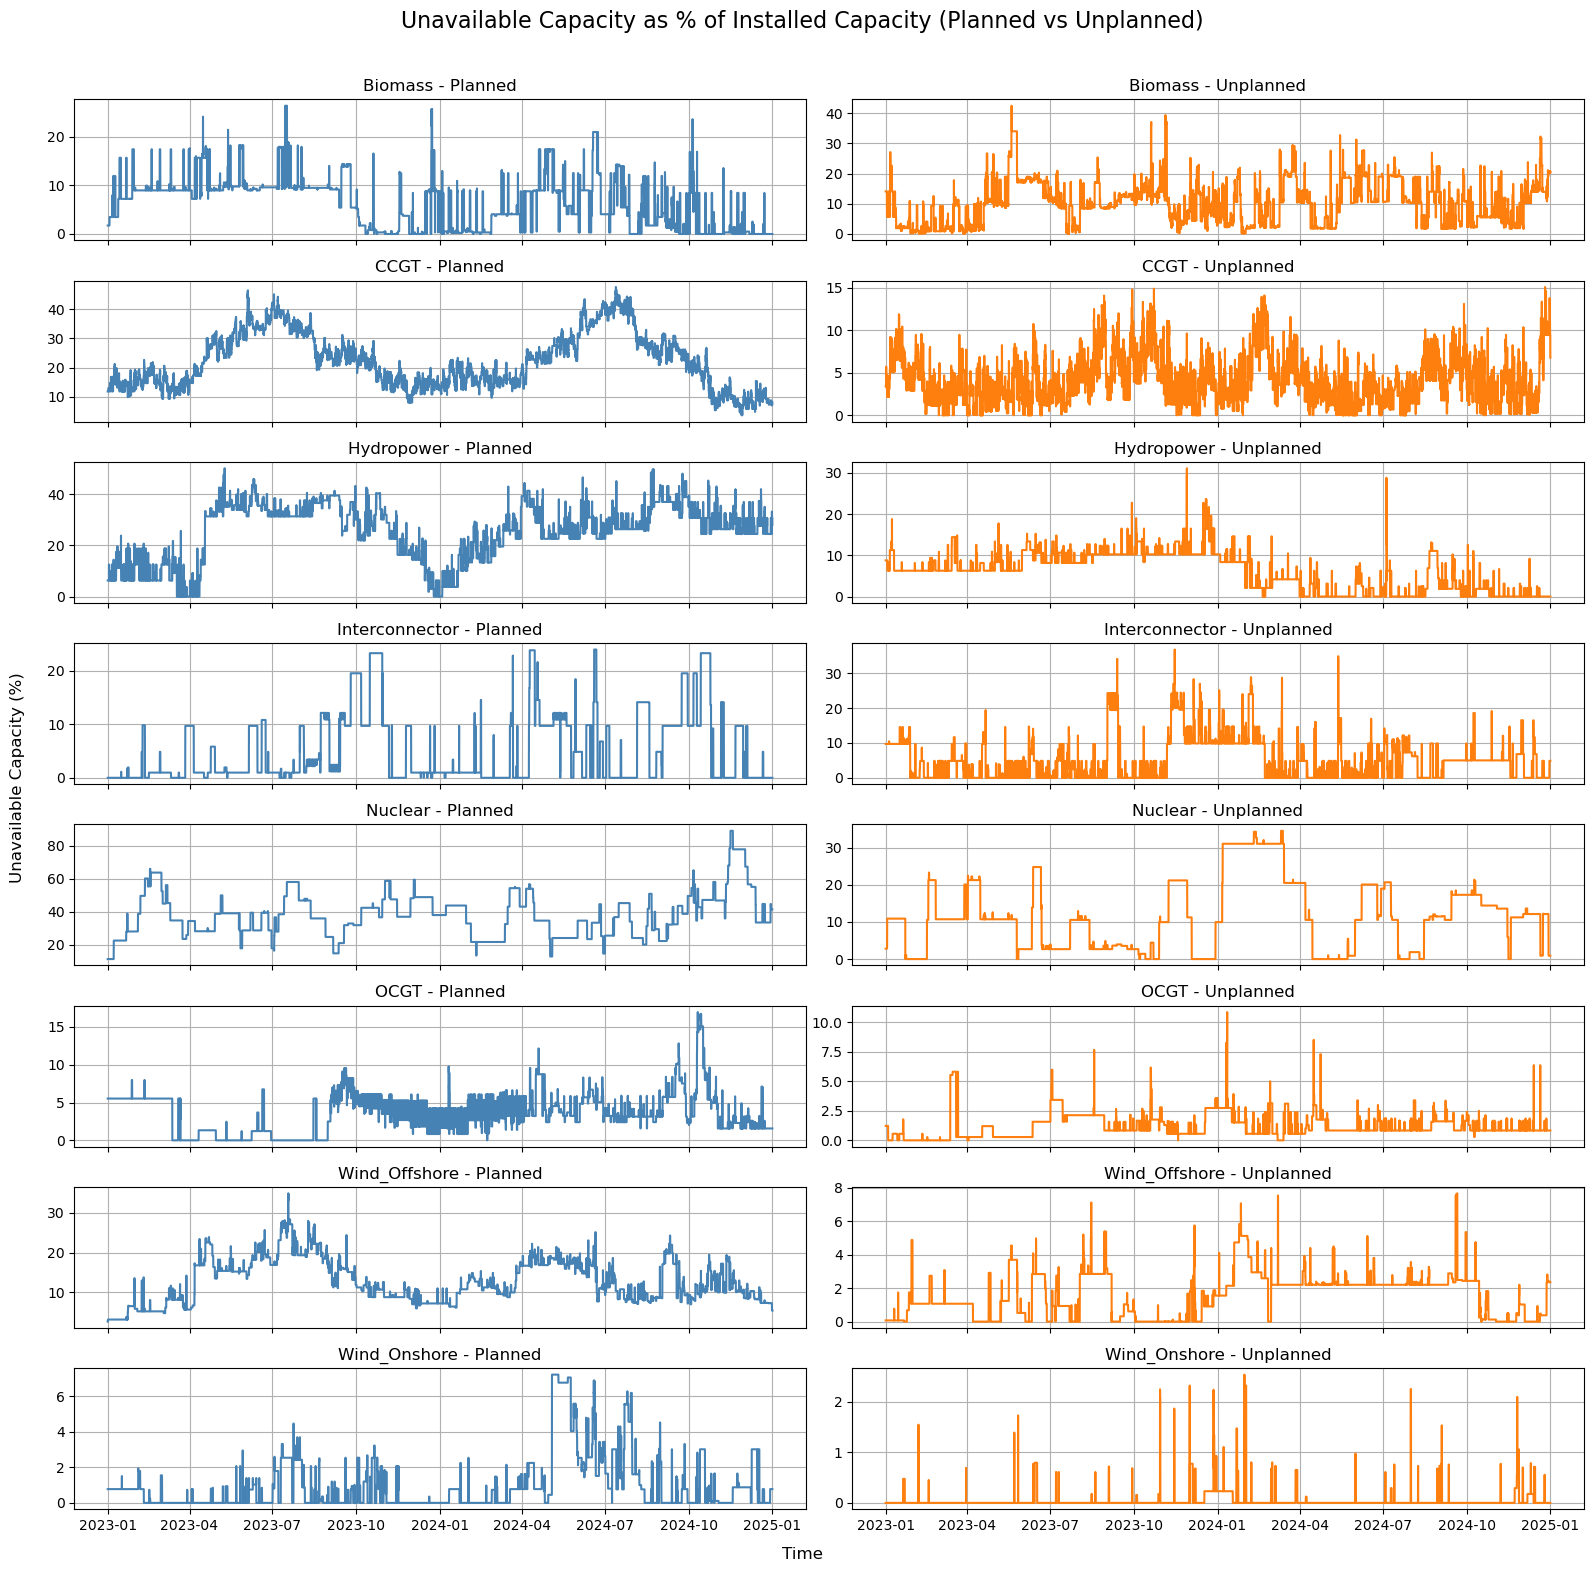

In [47]:
import matplotlib.pyplot as plt

# Step 1: Clean column names to extract fuel names
def strip_suffix(colname):
    return colname.replace('_Planned_%', '').replace('_Unplanned_%', '')

planned_clean = {col: strip_suffix(col) for col in normalized_planned.columns}
unplanned_clean = {col: strip_suffix(col) for col in normalized_unplanned.columns}

# Step 2: Rename columns
normalized_planned_cleaned = normalized_planned.rename(columns=planned_clean)
normalized_unplanned_cleaned = normalized_unplanned.rename(columns=unplanned_clean)

# Step 3: Find common fuel types
common_fuels = sorted(set(normalized_planned_cleaned.columns).intersection(normalized_unplanned_cleaned.columns))
num_fuels = len(common_fuels)

if num_fuels == 0:
    raise ValueError("No common fuel types found after cleaning column names.")

# Step 4: Align both DataFrames to the same columns
normalized_planned_cleaned = normalized_planned_cleaned[common_fuels]
normalized_unplanned_cleaned = normalized_unplanned_cleaned[common_fuels]

# Step 5: Create 2-column plot: Planned vs Unplanned
fig, axes = plt.subplots(nrows=num_fuels, ncols=2, figsize=(16, num_fuels * 2), sharex=True)

for i, fuel in enumerate(common_fuels):
    # Left column: Planned
    axes[i, 0].plot(normalized_planned_cleaned.index, normalized_planned_cleaned[fuel], color='steelblue')
    axes[i, 0].set_title(f"{fuel} - Planned")
    axes[i, 0].grid(True)

    # Right column: Unplanned
    axes[i, 1].plot(normalized_unplanned_cleaned.index, normalized_unplanned_cleaned[fuel], color='#ff7f0e')
    axes[i, 1].set_title(f"{fuel} - Unplanned")
    axes[i, 1].grid(True)

# Shared labels
fig.suptitle("Unavailable Capacity as % of Installed Capacity (Planned vs Unplanned)", fontsize=16)
fig.supxlabel("Time")
fig.supylabel("Unavailable Capacity (%)", x=0.005)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

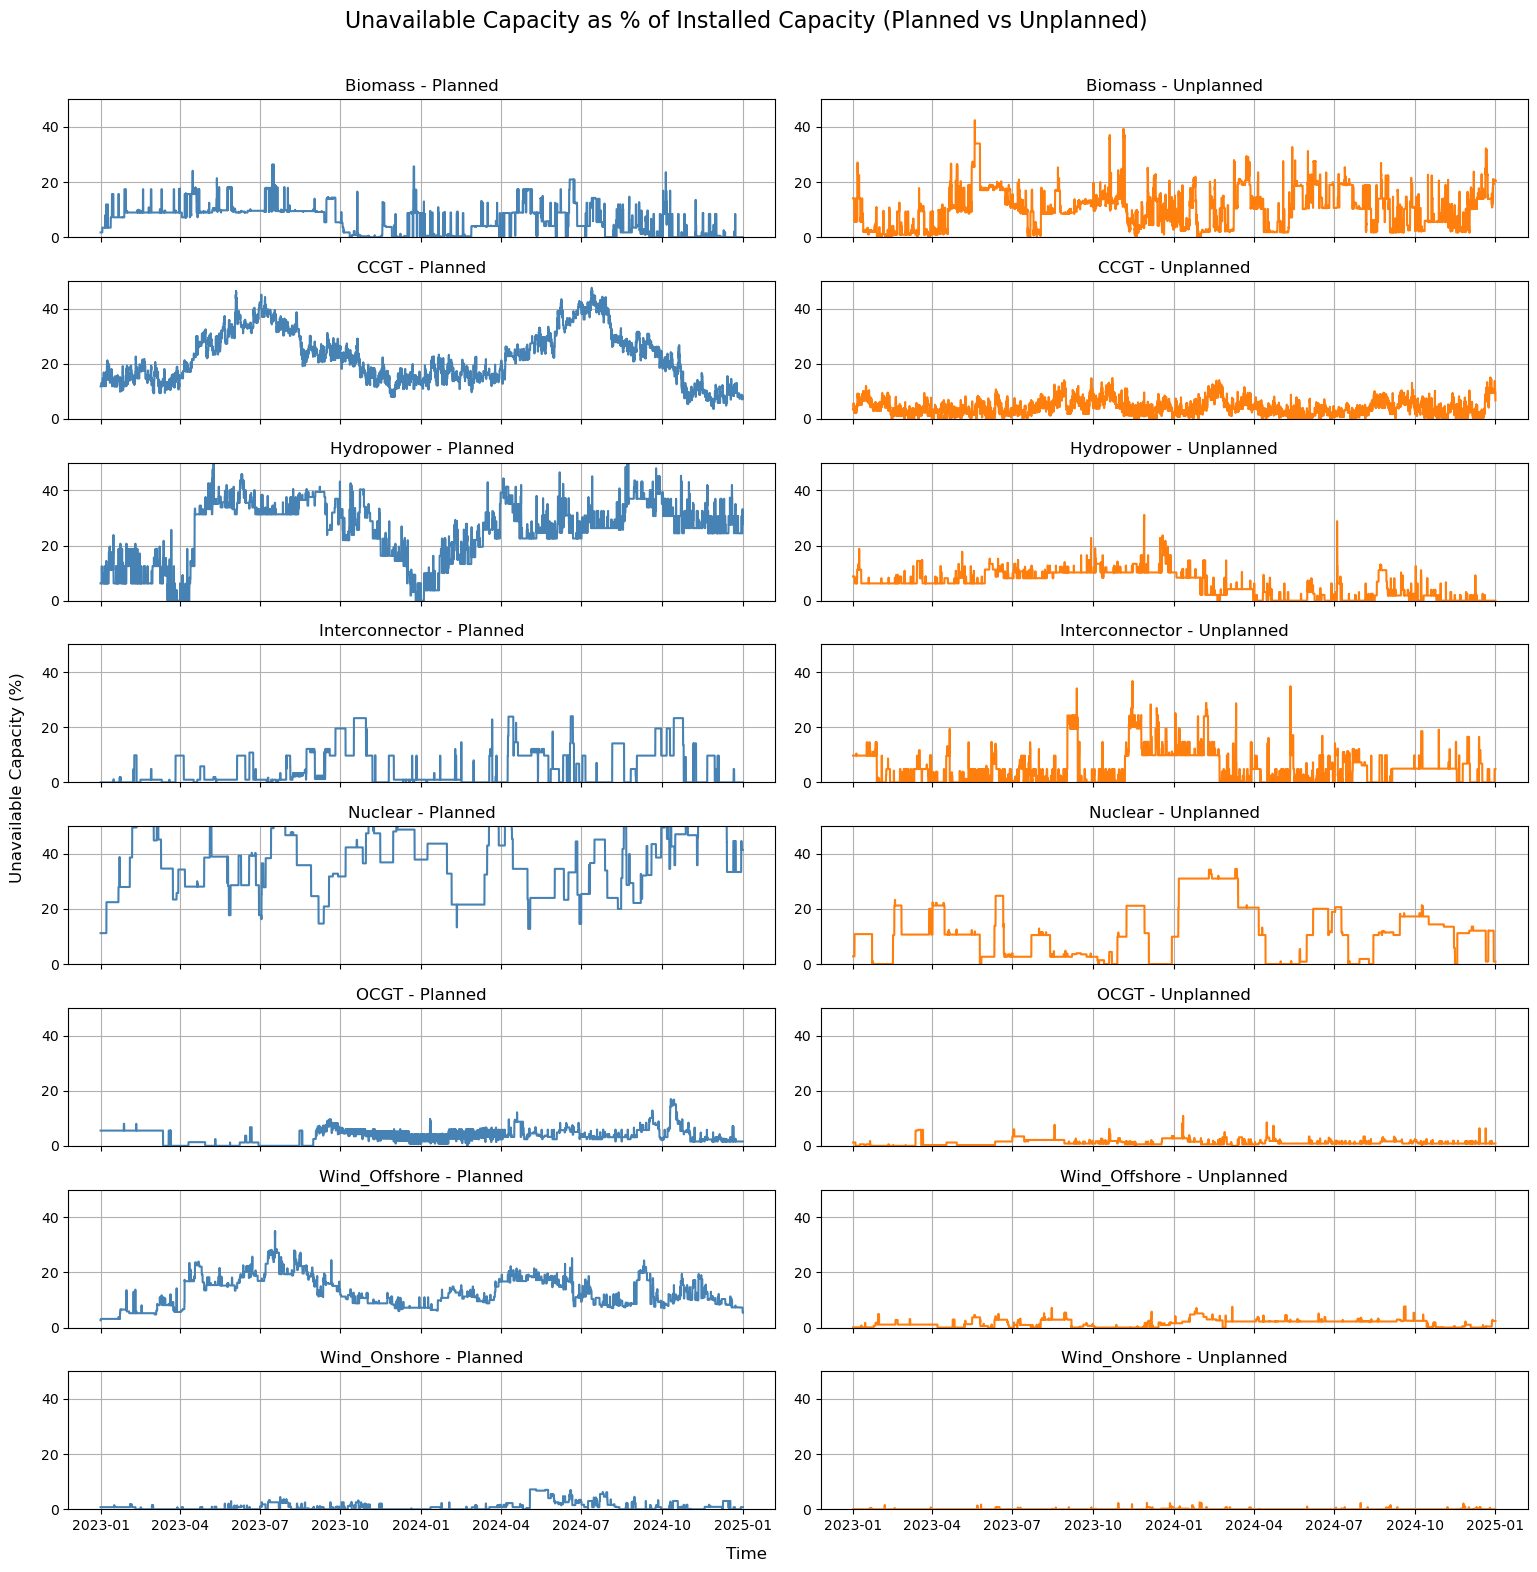

In [48]:
import matplotlib.pyplot as plt

# Step 1: Clean column names to extract fuel names
def strip_suffix(colname):
    return colname.replace('_Planned_%', '').replace('_Unplanned_%', '')

planned_clean = {col: strip_suffix(col) for col in normalized_planned.columns}
unplanned_clean = {col: strip_suffix(col) for col in normalized_unplanned.columns}

# Step 2: Rename columns
normalized_planned_cleaned = normalized_planned.rename(columns=planned_clean)
normalized_unplanned_cleaned = normalized_unplanned.rename(columns=unplanned_clean)

# Step 3: Find common fuel types
common_fuels = sorted(set(normalized_planned_cleaned.columns).intersection(normalized_unplanned_cleaned.columns))
num_fuels = len(common_fuels)

if num_fuels == 0:
    raise ValueError("No common fuel types found after cleaning column names.")

# Step 4: Align both DataFrames to the same columns
normalized_planned_cleaned = normalized_planned_cleaned[common_fuels]
normalized_unplanned_cleaned = normalized_unplanned_cleaned[common_fuels]

# Step 5: Create 2-column plot: Planned vs Unplanned
fig, axes = plt.subplots(nrows=num_fuels, ncols=2, figsize=(16, num_fuels * 2), sharex=True)

for i, fuel in enumerate(common_fuels):
    # Left column: Planned
    axes[i, 0].plot(normalized_planned_cleaned.index, normalized_planned_cleaned[fuel], color='steelblue')
    axes[i, 0].set_title(f"{fuel} - Planned")
    axes[i, 0].set_ylim(0, 50)
    axes[i, 0].grid(True)

    # Right column: Unplanned
    axes[i, 1].plot(normalized_unplanned_cleaned.index, normalized_unplanned_cleaned[fuel], color='#ff7f0e')
    axes[i, 1].set_title(f"{fuel} - Unplanned")
    axes[i, 1].set_ylim(0, 50)
    axes[i, 1].grid(True)

# Shared labels and spacing
fig.suptitle("Unavailable Capacity as % of Installed Capacity (Planned vs Unplanned)", fontsize=16)
fig.supxlabel("Time")
fig.text(0.04, 0.5, "Unavailable Capacity (%)", va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0, 1, 0.97])
plt.show()

In [49]:
# Save each pivot table to CSV
normalized_total.to_csv('REMIT_Unavailable_Capacity_Percentage_By_FuelType.csv')
normalized_planned.to_csv('REMIT_Unavailable_Capacity_Percentage_By_FuelType_Planned.csv')
normalized_unplanned.to_csv('REMIT_Unavailable_Capacity_Percentage_By_FuelType_Unplanned.csv')

In [50]:
import pandas as pd

# Step 1: Create copies
planned_renamed = normalized_planned.copy()
unplanned_renamed = normalized_unplanned.copy()

# Step 2: Merge on StartTime
normalized_combined = pd.merge(planned_renamed, unplanned_renamed, on='StartTime', how='outer')

# Step 3: Add new percentage columns using total installed capacity
total_installed_capacity = 105715 + 20600 # Total 2023 installed capacity from UK Gov excel file + Interconnectors (x2 for Demand and Generation)
#total_installed_capacity = installed_capacity_df['installedCapacity'].sum() 

# Extract planned/unplanned/total unavailability from the original MW-based DataFrame
merged_mw = pivot_capacity_per_fuel_planned_and_unplanned.groupby('StartTime')[[
    'Planned_Unavailability', 'Unplanned_Unavailability', 'Total_Unavailability'
]].sum().reset_index()

# Step 4: Merge these totals into the combined normalized dataframe
normalized_combined = normalized_combined.merge(merged_mw, on='StartTime', how='left')

# Step 5: Calculate overall unavailability percentages
normalized_combined['Planned_Unavailability_%'] = (
    normalized_combined['Planned_Unavailability'] / total_installed_capacity * 100
)

normalized_combined['Unplanned_Unavailability_%'] = (
    normalized_combined['Unplanned_Unavailability'] / total_installed_capacity * 100
)

normalized_combined['Total_Unavailability_%'] = (
    normalized_combined['Total_Unavailability'] / total_installed_capacity * 100
)

# Step 6: Drop MW columns now that percentages are calculated
normalized_combined.drop(columns=[
    'Planned_Unavailability', 'Unplanned_Unavailability', 'Total_Unavailability'
], inplace=True)
normalized_combined.set_index('StartTime', inplace=True)

# View dataframe
normalized_combined

Biomass_Planned_%  CCGT_Planned_%  Hydropower_Planned_%  \
StartTime                                                                      
2023-01-01 00:00:00           1.741522       11.826828              6.263048   
2023-01-01 00:30:00           1.741522       11.826828              6.263048   
2023-01-01 01:00:00           1.741522       11.826828              6.263048   
2023-01-01 01:30:00           1.741522       11.826828              6.263048   
2023-01-01 02:00:00           1.741522       11.826828              6.263048   
...                                ...             ...                   ...   
2024-12-31 21:30:00           0.000000        8.312786             30.688935   
2024-12-31 22:00:00           0.000000        8.312786             30.688935   
2024-12-31 22:30:00           0.000000        8.312786             30.688935   
2024-12-31 23:00:00           0.000000        7.457812             30.688935   
2024-12-31 23:30:00           0.000000        7.457812             27.974948   

                     Interconnector_Planned_%  Nuclear_Planned_%  \
StartTime                                                          
2023-01-01 00:00:00                       0.0          11.235764   
2023-01-01 00:30:00                       0.0          11.235764   
2023-01-01 01:00:00                       0.0          11.235764   
2023-01-01 01:30:00                       0.0          11.235764   
2023-01-01 02:00:00                       0.0          11.235764   
...                                       ...                ...   
2024-12-31 21:30:00                       0.0          41.390447   
2024-12-31 22:00:00                       0.0          41.390447   
2024-12-31 22:30:00                       0.0          41.390447   
2024-12-31 23:00:00                       0.0          41.390447   
2024-12-31 23:30:00                       0.0          41.390447   

                     OCGT_Planned_%  Wind_Offshore_Planned_%  \
StartTime                                                      
2023-01-01 00:00:00        5.526802                 2.620314   
2023-01-01 00:30:00        5.526802                 2.620314   
2023-01-01 01:00:00        5.526802                 2.620314   
2023-01-01 01:30:00        5.526802                 2.620314   
2023-01-01 02:00:00        5.526802                 2.620314   
...                             ...                      ...   
2024-12-31 21:30:00        1.571165                 5.354780   
2024-12-31 22:00:00        1.571165                 5.354780   
2024-12-31 22:30:00        1.571165                 5.354780   
2024-12-31 23:00:00        1.571165                 5.354780   
2024-12-31 23:30:00        1.571165                 5.354780   

                     Wind_Onshore_Planned_%  Biomass_Unplanned_%  \
StartTime                                                          
2023-01-01 00:00:00                0.773143            14.115490   
2023-01-01 00:30:00                0.773143            14.115490   
2023-01-01 01:00:00                0.773143            14.115490   
2023-01-01 01:30:00                0.773143            14.115490   
2023-01-01 02:00:00                0.773143            14.115490   
...                                     ...                  ...   
2024-12-31 21:30:00                0.773143            20.348304   
2024-12-31 22:00:00                0.773143            20.348304   
2024-12-31 22:30:00                0.773143            20.348304   
2024-12-31 23:00:00                0.773143            20.348304   
2024-12-31 23:30:00                0.773143            20.348304   

                     CCGT_Unplanned_%  Hydropower_Unplanned_%  \
StartTime                                                       
2023-01-01 00:00:00          3.394281                8.768267   
2023-01-01 00:30:00          3.394281                8.768267   
2023-01-01 01:00:00          3.394281                8.768267   
2023-01-01 01:30:00          3.394281               

In [51]:
# Save dataframe
#normalized_combined.to_csv('REMIT_Unavailable_Capacity_Percentage_By_FuelType_And_Availability_Type.csv')